# In Codice Ratio Convolutional Neural Network - Test on known words

In [1]:
import os
from IPython.display import Image
import time

from util import Util
u = Util()
import image_utils as iu
import keras_image_utils as kiu

import numpy as np
# Explicit random seed for reproducibility
np.random.seed(1337)

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Merge

In [3]:
import dataset_generator as dataset

## Loading test sets

In [4]:
# letter list
ALPHABET_ALL = dataset.ALPHABET_ALL

(_, _, X_test_22, y_test_22, _) = dataset.generate_all_chars_with_class(verbose=0, plot=False)
(input_shape, X_test_22, Y_test_22) = kiu.adjust_input_output(X_test_22, y_test_22, 22) 
print ("Loaded test set for all the characters")

(_, _, X_test_seg, y_test_seg) = dataset.generate_dataset_for_segmentator(verbose=0, plot=False)
(_, X_test_seg, Y_test_seg) = kiu.adjust_input_output(X_test_seg, y_test_seg, 2)
print ("Loaded test set for good and bad segments")

X_test_char = {}
y_test_char = {}
Y_test_char = {}
for char in ALPHABET_ALL:
    (_, _, X_test_char[char], y_test_char[char]) = dataset.generate_positive_and_negative_labeled(char, verbose=0)
    (_, X_test_char[char], Y_test_char[char]) = kiu.adjust_input_output(X_test_char[char], y_test_char[char], 2)
    print ("Loaded test set for char '" + char + "'")

Loaded test set for all the characters
Loaded test set for good and bad segments
Loaded test set for char 'a'
Loaded test set for char 'c'
Loaded test set for char 'd_mediana'
Loaded test set for char 'e'
Loaded test set for char 'i'
Loaded test set for char 'm'
Loaded test set for char 'n'
Loaded test set for char 'o'
Loaded test set for char 'r'
Loaded test set for char 's_mediana'
Loaded test set for char 't'
Loaded test set for char 'u'
Loaded test set for char 'd_alta'
Loaded test set for char 's_alta'
Loaded test set for char 'b'
Loaded test set for char 'f'
Loaded test set for char 'h'
Loaded test set for char 'l'
Loaded test set for char 'g'
Loaded test set for char 'p'
Loaded test set for char 'q'
Loaded test set for char 's_bassa'


## Constants

In [5]:
# input image dimensions
img_rows, img_cols = 34, 56

# number of networks for ensamble learning
number_of_models = 5

# checkpoints dir
checkpoints_dir = "checkpoints"

# size of pooling area for max pooling
pool_size1 = (2, 2)
pool_size2 = (3, 3)
# convolution kernel size
kernel_size1 = (4, 4)
kernel_size2 = (5, 5)
# dropout rate
dropout = 0.15
# activation
activation = 'relu'

## Helper functions for model definition and load

In [6]:
def initialize_network_single_column(model, nb_classes, nb_filters1, nb_filters2, dense_layer_size1):
    model.add(Convolution2D(nb_filters1, kernel_size1[0], kernel_size1[1],
                            border_mode='valid',
                            input_shape=input_shape, name='covolution_1_' + str(nb_filters1) + '_filters'))
    model.add(Activation(activation, name='activation_1_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size1, name='max_pooling_1_' + str(pool_size1) + '_pool_size'))
    model.add(Convolution2D(nb_filters2, kernel_size2[0], kernel_size2[1]))
    model.add(Activation(activation, name='activation_2_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size2, name='max_pooling_1_' + str(pool_size2) + '_pool_size'))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(dense_layer_size1, name='fully_connected_1_' + str(dense_layer_size1) + '_neurons'))
    model.add(Activation(activation, name='activation_3_' + activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, name='output_' + str(nb_classes) + '_neurons'))
    model.add(Activation('softmax', name='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy', 'precision', 'recall'])

def try_load_checkpoints(model, checkpoints_filepath, warn=True):
    # loading weights from checkpoints 
    if os.path.exists(checkpoints_filepath):
        model.load_weights(checkpoints_filepath)
    elif warn: 
        print('Warning: ' + checkpoints_filepath + ' could not be loaded')

def initialize_network_multi_column(merged_model, models):
    merged_model.add(Merge(models, mode='ave'))
    merged_model.compile(loss='categorical_crossentropy',
                         optimizer='adadelta',
                         metrics=['accuracy', 'precision', 'recall'])

def create_and_load_network(number_of_models, checkpoint_paths, nb_classes, 
                            nb_filters1, nb_filters2, dense_layer_size1):
    # pseudo random generation of seeds
    seeds = np.random.randint(10000, size=number_of_models)

    # initializing all the models
    models = [None] * number_of_models

    for i in range(number_of_models):
        models[i] = Sequential()
        initialize_network_single_column(models[i], nb_classes, nb_filters1, nb_filters2, dense_layer_size1)
        try_load_checkpoints(models[i], checkpoint_paths[i])
        
    # initializing merged model
    merged_model = Sequential()
    initialize_network_multi_column(merged_model, models)
    
    return (merged_model, models)

## Model load

In [7]:
# 22 classes ocr
ocr_weigts_dir = os.path.join(checkpoints_dir, "09_22-classes")
ocr_weights = [os.path.join(ocr_weigts_dir, "09_ICR_weights.best_0.hdf5"), 
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_1.hdf5"),
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_2.hdf5"),
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_3.hdf5"),
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_4.hdf5")]
(ocr_model, _) = create_and_load_network(5, ocr_weights, 22, 50, 100, 250)
score = ocr_model.evaluate([np.asarray(X_test_22)] * number_of_models, Y_test_22, verbose=0)
print ("Loaded 22 classes orc model with test error of ", (1-score[2])*100, '%')

# segmentator network (good cut / bad cut)
segmentator_weigts_dir = os.path.join(checkpoints_dir, "letter_not_letter")
segmentator_weights = [os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_0.hdf5"), 
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_1.hdf5"),
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_2.hdf5"),
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_3.hdf5"),
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_4.hdf5")]
(segmentator_model, _) = create_and_load_network(5, segmentator_weights, 2, 50, 100, 250)
score = segmentator_model.evaluate([np.asarray(X_test_seg)] * number_of_models, Y_test_seg, verbose=0)
print ("Loaded binary segmentator model with test error of ", (1-score[2])*100, '%')
print ("---")

# single letter segmentator / ocr 
single_letter_models = {}
single_letter_weights_dir = {}
single_letter_weights = {}
errors = []
for char in ALPHABET_ALL:
    single_letter_weights_dir[char] = os.path.join(checkpoints_dir, char)
    single_letter_weights[char] = [os.path.join(single_letter_weights_dir[char], "0.hdf5"), 
                                   os.path.join(single_letter_weights_dir[char], "1.hdf5"),
                                   os.path.join(single_letter_weights_dir[char], "2.hdf5"),
                                   os.path.join(single_letter_weights_dir[char], "3.hdf5"),
                                   os.path.join(single_letter_weights_dir[char], "4.hdf5")]
    (single_letter_models[char], _) = create_and_load_network(5, single_letter_weights[char], 2, 20, 40, 150)
    score = single_letter_models[char].evaluate([np.asarray(X_test_char[char])] * number_of_models, Y_test_char[char], verbose=0)
    print ("Loaded binary model for '" + char + "', with test error of ", (1-score[2])*100, '%')
    errors.append(1-score[2])
print("Average test error: ", sum(errors) / float(len(errors)) * 100, "%")

Loaded 22 classes orc model with test error of  4.60439568125 %
Loaded binary segmentator model with test error of  5.15200979392 %
---
Loaded binary model for 'a', with test error of  5.76923082017 %
Loaded binary model for 'c', with test error of  7.44680889109 %
Loaded binary model for 'd_mediana', with test error of  3.4482760676 %
Loaded binary model for 'e', with test error of  3.34158415842 %
Loaded binary model for 'i', with test error of  17.9824561404 %
Loaded binary model for 'm', with test error of  9.44700471817 %
Loaded binary model for 'n', with test error of  11.2903225593 %
Loaded binary model for 'o', with test error of  7.35294129334 %
Loaded binary model for 'r', with test error of  6.66666653421 %
Loaded binary model for 's_mediana', with test error of  3.33333611488 %
Loaded binary model for 't', with test error of  5.47945205479 %
Loaded binary model for 'u', with test error of  15.5487804878 %
Loaded binary model for 'd_alta', with test error of  2.32558139535 %

## Helper functions for prediction

In [8]:
def predict_pipeline1(data, count_letter=True):
    start_time = time.time()
    count = 0
    for bad_cut in data:
        flag = False
        count += 1
        bad_cuts = np.asarray([bad_cut])
        if count_letter:
            print ("Predictions for the supposed letter number " + str(count))
        for char in ALPHABET_ALL:
            predictions = single_letter_models[char].predict([bad_cuts] * number_of_models)
            if (predictions[0][1] > predictions[0][0]):
                print ("Cut " + str(count) + " has been classified as good corresponding to char '" +\
                       char + "' with a confidence of " + str(predictions[0][1] * 100) + "%")
                flag = True
        if not flag:
            print ("Bad cut")
        #print ("---")
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)
    print("---")
    print(" ")
        
def predict_pipeline2(data, count_letter=True):
    start_time = time.time()
    count = 0
    for bad_cut in data:
        count += 1
        bad_cuts = np.asarray([bad_cut])
        if count_letter:
            print ("Predictions for the supposed letter number " + str(count))
        predictions = segmentator_model.predict([bad_cuts] * number_of_models)
        if (predictions[0][1] > predictions[0][0]):
            predictions = ocr_model.predict([bad_cuts] * number_of_models)
            ind = (-predictions[0]).argsort()[:3]
            for i in ind:
                print ("Good cut corresponding to letter '" + ALPHABET_ALL[i] + \
                   "' with a confidence of " + str(predictions[0][i] * 100) + "%")
        else: 
            print ("Bad cut with a confidence of " + str(predictions[0][0] * 100) + "%")
        #print ("---")
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)
    print("---")
    print(" ")
        
def predict_pipeline3(data, count_letter=True):
    start_time = time.time()
    count = 0
    for bad_cut in data:
        flag = False
        count += 1
        bad_cuts = np.asarray([bad_cut])
        if count_letter:
            print ("Predictions for the supposed letter number " + str(count))
        for char in ALPHABET_ALL:
            predictions = single_letter_models[char].predict([bad_cuts] * number_of_models)
            if (predictions[0][1] > predictions[0][0]):
                print ("Good cut with a confidence of " + str(predictions[0][1] * 100) + "% by letter '" + char + "'")
                flag = True
        if flag:
            predictions = ocr_model.predict([bad_cuts] * number_of_models)
            ind = (-predictions[0]).argsort()[:3]
            for i in ind:
                print ("Good cut corresponding to letter '" + ALPHABET_ALL[i] + \
                   "' with a confidence of " + str(predictions[0][i] * 100) + "%")
        else: 
            print ("Bad cut")
        #print ("---")
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)
    print("---")
    print(" ")

def predict_pipeline4(data, count_letter=True):
    start_time = time.time()
    count = 0
    for bad_cut in data:
        count += 1
        bad_cuts = np.asarray([bad_cut])
        if count_letter:
            print ("Predictions for the supposed letter number " + str(count))
        predictions = segmentator_model.predict([bad_cuts] * number_of_models)
        if (predictions[0][1] > predictions[0][0]):
            for char in ALPHABET_ALL:
                predictions = single_letter_models[char].predict([bad_cuts] * number_of_models)
                if (predictions[0][1] > predictions[0][0]):
                    print ("Good cut with a confidence of " + str(predictions[0][1] * 100) + "% by letter '" + char + "'")
        else: 
            print ("Bad cut with a confidence of " + str(predictions[0][0] * 100) + "%")
        #print ("---")
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)
    print("---")
    print(" ")

## Experiment

#### Helper-function for sorting an array of strings in human order

In [9]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

### "Asseras"

Examples: 


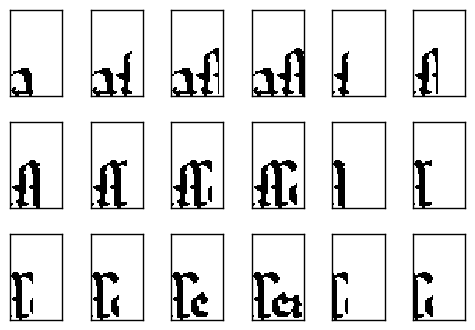

In [10]:
files = []
folders = []
for (path, dirnames, filenames) in os.walk(os.path.join('not_code',os.path.join('word_segments','asseras'))):
    folders.extend(os.path.join(path, name) for name in dirnames)
    files.extend(os.path.join(path, name) for name in filenames)

files.sort(key=natural_keys)

cuts = iu.open_many_samples(files)
(cuts, _) = kiu.adjust_input(np.asarray(cuts))

print ("Examples: ")
u.plot_some_images(cuts[:18], (img_cols, img_rows), grid_x=6, grid_y=3)

Cut number  1


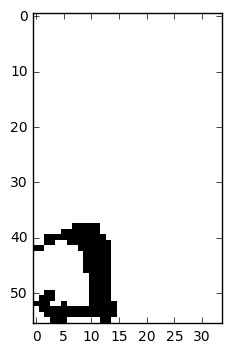

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 98.8626360893%
Elapsed time: 15.847002267837524
---
 
Pipeline 2
Good cut corresponding to letter 'a' with a confidence of 99.9038100243%
Good cut corresponding to letter 'i' with a confidence of 0.0953157141339%
Good cut corresponding to letter 't' with a confidence of 0.000513017312187%
Elapsed time: 1.4580004215240479
---
 
Pipeline 3
Good cut with a confidence of 98.8626360893% by letter 'a'
Good cut corresponding to letter 'a' with a confidence of 99.9038100243%
Good cut corresponding to letter 'i' with a confidence of 0.0953157141339%
Good cut corresponding to letter 't' with a confidence of 0.000513017312187%
Elapsed time: 0.10799980163574219
---
 
Pipeline 4
Good cut with a confidence of 98.8626360893% by letter 'a'
Elapsed time: 0.10400223731994629
---
 
---------
 
Cut number  2


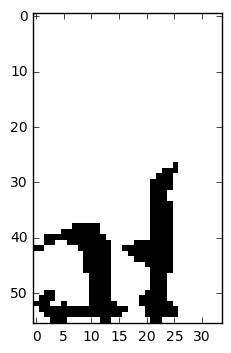

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 55.9251129627%
Elapsed time: 0.09999656677246094
---
 
Pipeline 2
Bad cut with a confidence of 99.9996185303%
Elapsed time: 0.007000446319580078
---
 
Pipeline 3
Good cut with a confidence of 55.9251129627% by letter 's_mediana'
Good cut corresponding to letter 'b' with a confidence of 98.3418464661%
Good cut corresponding to letter 'h' with a confidence of 1.658119075%
Good cut corresponding to letter 's_bassa' with a confidence of 1.22392933122e-05%
Elapsed time: 0.10500121116638184
---
 
Pipeline 4
Bad cut with a confidence of 99.9996185303%
Elapsed time: 0.006998538970947266
---
 
---------
 
Cut number  3


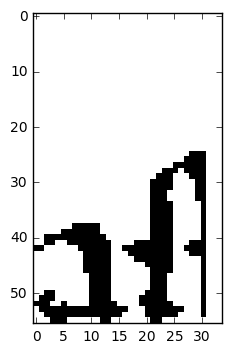

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 97.631072998%
Elapsed time: 0.10299849510192871
---
 
Pipeline 2
Bad cut with a confidence of 100.0%
Elapsed time: 0.0060002803802490234
---
 
Pipeline 3
Good cut with a confidence of 97.631072998% by letter 's_mediana'
Good cut corresponding to letter 'f' with a confidence of 52.3519098759%
Good cut corresponding to letter 'b' with a confidence of 46.2154775858%
Good cut corresponding to letter 'q' with a confidence of 0.974210724235%
Elapsed time: 0.10299992561340332
---
 
Pipeline 4
Bad cut with a confidence of 100.0%
Elapsed time: 0.005001068115234375
---
 
---------
 
Cut number  4


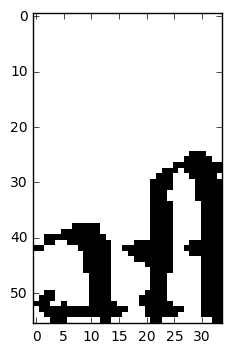

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 94.1678702831%
Elapsed time: 0.10300064086914062
---
 
Pipeline 2
Bad cut with a confidence of 100.0%
Elapsed time: 0.0050008296966552734
---
 
Pipeline 3
Good cut with a confidence of 94.1678702831% by letter 's_mediana'
Good cut corresponding to letter 'g' with a confidence of 53.7946105003%
Good cut corresponding to letter 'q' with a confidence of 45.5809175968%
Good cut corresponding to letter 'f' with a confidence of 0.592150911689%
Elapsed time: 0.10799932479858398
---
 
Pipeline 4
Bad cut with a confidence of 100.0%
Elapsed time: 0.006999015808105469
---
 
---------
 
Cut number  5


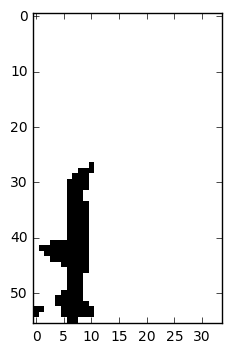

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 64.7860765457%
Cut 1 has been classified as good corresponding to char 'h' with a confidence of 55.3113341331%
Elapsed time: 0.10699868202209473
---
 
Pipeline 2
Bad cut with a confidence of 99.8558521271%
Elapsed time: 0.006000995635986328
---
 
Pipeline 3
Good cut with a confidence of 64.7860765457% by letter 'i'
Good cut with a confidence of 55.3113341331% by letter 'h'
Good cut corresponding to letter 'l' with a confidence of 98.3173966408%
Good cut corresponding to letter 's_alta' with a confidence of 1.67910363525%
Good cut corresponding to letter 'b' with a confidence of 0.00202531118703%
Elapsed time: 0.10499906539916992
---
 
Pipeline 4
Bad cut with a confidence of 99.8558521271%
Elapsed time: 0.006000518798828125
---
 
---------
 
Cut number  6


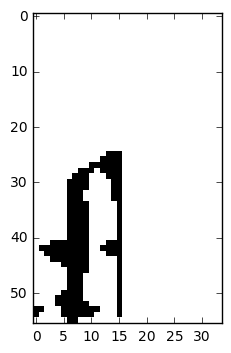

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 86.1715912819%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 86.3766074181%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 62.6808702946%
Elapsed time: 0.09499883651733398
---
 
Pipeline 2
Good cut corresponding to letter 's_alta' with a confidence of 70.0819790363%
Good cut corresponding to letter 'f' with a confidence of 26.5692085028%
Good cut corresponding to letter 'b' with a confidence of 3.15949395299%
Elapsed time: 0.012000322341918945
---
 
Pipeline 3
Good cut with a confidence of 86.1715912819% by letter 's_mediana'
Good cut with a confidence of 86.3766074181% by letter 's_alta'
Good cut with a confidence of 62.6808702946% by letter 'f'
Good cut corresponding to letter 's_alta' with a confidence of 70.0819790363%
Good cut corresponding to letter 'f' with a confidence of 26.5692085028%
Good cut correspondi

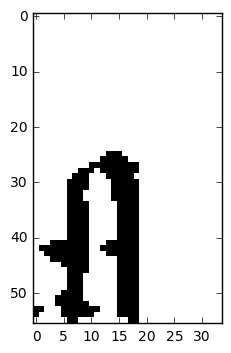

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 54.2401432991%
Cut 1 has been classified as good corresponding to char 'h' with a confidence of 50.3024756908%
Cut 1 has been classified as good corresponding to char 'g' with a confidence of 50.7311105728%
Elapsed time: 0.0989985466003418
---
 
Pipeline 2
Bad cut with a confidence of 98.9865481853%
Elapsed time: 0.0060007572174072266
---
 
Pipeline 3
Good cut with a confidence of 54.2401432991% by letter 's_mediana'
Good cut with a confidence of 50.3024756908% by letter 'h'
Good cut with a confidence of 50.7311105728% by letter 'g'
Good cut corresponding to letter 'q' with a confidence of 81.7986190319%
Good cut corresponding to letter 'g' with a confidence of 17.3811480403%
Good cut corresponding to letter 'f' with a confidence of 0.305235665292%
Elapsed time: 0.10399985313415527
---
 
Pipeline 4
Bad cut with a confidence of 98.9865481853%
Elapsed time: 0.005998849868774414
---
 
-----

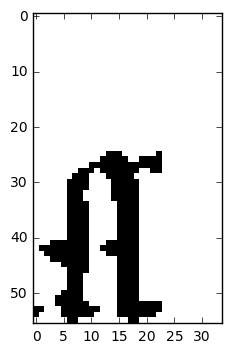

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 68.9669251442%
Cut 1 has been classified as good corresponding to char 'g' with a confidence of 86.5418434143%
Elapsed time: 0.09499931335449219
---
 
Pipeline 2
Bad cut with a confidence of 88.4649097919%
Elapsed time: 0.006000041961669922
---
 
Pipeline 3
Good cut with a confidence of 68.9669251442% by letter 's_mediana'
Good cut with a confidence of 86.5418434143% by letter 'g'
Good cut corresponding to letter 'g' with a confidence of 61.7061376572%
Good cut corresponding to letter 'q' with a confidence of 38.2281631231%
Good cut corresponding to letter 's_alta' with a confidence of 0.0406776729506%
Elapsed time: 0.10100364685058594
---
 
Pipeline 4
Bad cut with a confidence of 88.4649097919%
Elapsed time: 0.005997419357299805
---
 
---------
 
Cut number  9


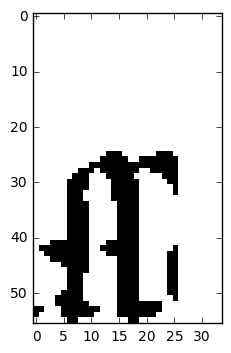

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 92.9725766182%
Cut 1 has been classified as good corresponding to char 'g' with a confidence of 87.4146819115%
Elapsed time: 0.09799909591674805
---
 
Pipeline 2
Bad cut with a confidence of 98.2478022575%
Elapsed time: 0.006001710891723633
---
 
Pipeline 3
Good cut with a confidence of 92.9725766182% by letter 's_mediana'
Good cut with a confidence of 87.4146819115% by letter 'g'
Good cut corresponding to letter 'g' with a confidence of 94.8109984398%
Good cut corresponding to letter 'q' with a confidence of 5.18292076886%
Good cut corresponding to letter 'p' with a confidence of 0.0032584532164%
Elapsed time: 0.0970005989074707
---
 
Pipeline 4
Bad cut with a confidence of 98.2478022575%
Elapsed time: 0.0059986114501953125
---
 
---------
 
Cut number  10


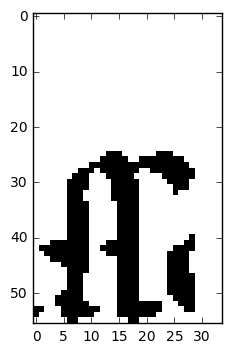

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 89.6165251732%
Cut 1 has been classified as good corresponding to char 'g' with a confidence of 54.4927000999%
Elapsed time: 0.09699797630310059
---
 
Pipeline 2
Bad cut with a confidence of 99.996393919%
Elapsed time: 0.00500178337097168
---
 
Pipeline 3
Good cut with a confidence of 89.6165251732% by letter 's_mediana'
Good cut with a confidence of 54.4927000999% by letter 'g'
Good cut corresponding to letter 'g' with a confidence of 96.7752456665%
Good cut corresponding to letter 'q' with a confidence of 1.78066361696%
Good cut corresponding to letter 'p' with a confidence of 1.28224417567%
Elapsed time: 0.09899783134460449
---
 
Pipeline 4
Bad cut with a confidence of 99.996393919%
Elapsed time: 0.00600123405456543
---
 
---------
 
Cut number  11


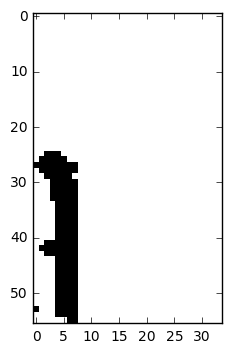

Pipeline 1
Cut 1 has been classified as good corresponding to char 'h' with a confidence of 50.0511348248%
Cut 1 has been classified as good corresponding to char 'l' with a confidence of 97.3290324211%
Elapsed time: 0.09999632835388184
---
 
Pipeline 2
Good cut corresponding to letter 'l' with a confidence of 100.0%
Good cut corresponding to letter 's_alta' with a confidence of 1.73802661152e-06%
Good cut corresponding to letter 'p' with a confidence of 1.48245443699e-08%
Elapsed time: 0.01100301742553711
---
 
Pipeline 3
Good cut with a confidence of 50.0511348248% by letter 'h'
Good cut with a confidence of 97.3290324211% by letter 'l'
Good cut corresponding to letter 'l' with a confidence of 100.0%
Good cut corresponding to letter 's_alta' with a confidence of 1.73802661152e-06%
Good cut corresponding to letter 'p' with a confidence of 1.48245443699e-08%
Elapsed time: 0.09999823570251465
---
 
Pipeline 4
Good cut with a confidence of 50.0511348248% by letter 'h'
Good cut with a con

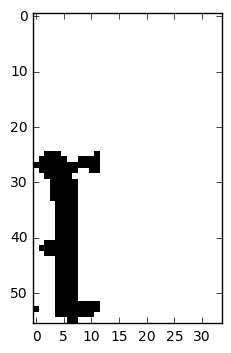

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 62.2088193893%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 71.038544178%
Cut 1 has been classified as good corresponding to char 'l' with a confidence of 81.0768604279%
Elapsed time: 0.09499883651733398
---
 
Pipeline 2
Good cut corresponding to letter 'l' with a confidence of 99.9914169312%
Good cut corresponding to letter 's_alta' with a confidence of 0.00857844570419%
Good cut corresponding to letter 'p' with a confidence of 1.51150025829e-06%
Elapsed time: 0.011996269226074219
---
 
Pipeline 3
Good cut with a confidence of 62.2088193893% by letter 's_mediana'
Good cut with a confidence of 71.038544178% by letter 's_alta'
Good cut with a confidence of 81.0768604279% by letter 'l'
Good cut corresponding to letter 'l' with a confidence of 99.9914169312%
Good cut corresponding to letter 's_alta' with a confidence of 0.00857844570419%
Good cut cor

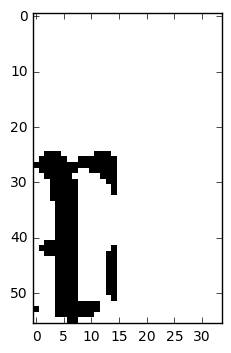

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 90.7496452332%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 89.2665028572%
Elapsed time: 0.10899782180786133
---
 
Pipeline 2
Good cut corresponding to letter 's_alta' with a confidence of 70.2478766441%
Good cut corresponding to letter 'p' with a confidence of 28.2194435596%
Good cut corresponding to letter 'l' with a confidence of 1.33457258344%
Elapsed time: 0.012000083923339844
---
 
Pipeline 3
Good cut with a confidence of 90.7496452332% by letter 's_mediana'
Good cut with a confidence of 89.2665028572% by letter 's_alta'
Good cut corresponding to letter 's_alta' with a confidence of 70.2478766441%
Good cut corresponding to letter 'p' with a confidence of 28.2194435596%
Good cut corresponding to letter 'l' with a confidence of 1.33457258344%
Elapsed time: 0.10200142860412598
---
 
Pipeline 4
Good cut with a confidence of 90.7496452332% by let

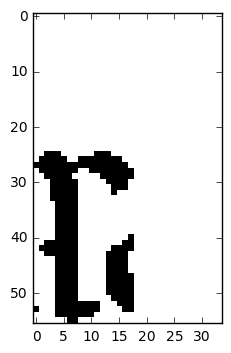

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 92.3968315125%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 66.1627173424%
Elapsed time: 0.09799671173095703
---
 
Pipeline 2
Bad cut with a confidence of 98.2041954994%
Elapsed time: 0.005001068115234375
---
 
Pipeline 3
Good cut with a confidence of 92.3968315125% by letter 's_mediana'
Good cut with a confidence of 66.1627173424% by letter 's_alta'
Good cut corresponding to letter 's_alta' with a confidence of 97.4476933479%
Good cut corresponding to letter 'p' with a confidence of 2.04282514751%
Good cut corresponding to letter 'f' with a confidence of 0.48910016194%
Elapsed time: 0.09799861907958984
---
 
Pipeline 4
Bad cut with a confidence of 98.2041954994%
Elapsed time: 0.005001544952392578
---
 
---------
 
Cut number  15


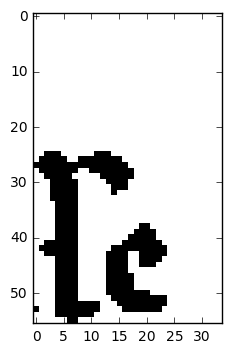

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 97.9869246483%
Elapsed time: 0.09999871253967285
---
 
Pipeline 2
Bad cut with a confidence of 99.920129776%
Elapsed time: 0.0060024261474609375
---
 
Pipeline 3
Good cut with a confidence of 97.9869246483% by letter 's_mediana'
Good cut corresponding to letter 'f' with a confidence of 68.8174664974%
Good cut corresponding to letter 'p' with a confidence of 20.4591006041%
Good cut corresponding to letter 's_alta' with a confidence of 10.1308144629%
Elapsed time: 0.09799838066101074
---
 
Pipeline 4
Bad cut with a confidence of 99.920129776%
Elapsed time: 0.005999565124511719
---
 
---------
 
Cut number  16


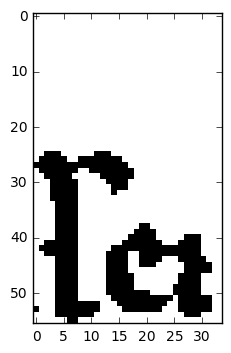

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 97.463619709%
Elapsed time: 0.09799695014953613
---
 
Pipeline 2
Bad cut with a confidence of 100.0%
Elapsed time: 0.0070002079010009766
---
 
Pipeline 3
Good cut with a confidence of 97.463619709% by letter 's_mediana'
Good cut corresponding to letter 'f' with a confidence of 89.0443921089%
Good cut corresponding to letter 'b' with a confidence of 9.27652344108%
Good cut corresponding to letter 'p' with a confidence of 1.56954042614%
Elapsed time: 0.10400009155273438
---
 
Pipeline 4
Bad cut with a confidence of 100.0%
Elapsed time: 0.0049991607666015625
---
 
---------
 
Cut number  17


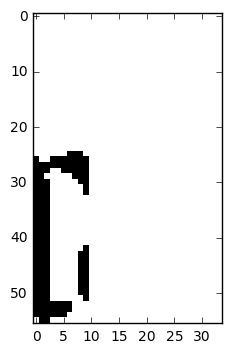

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 63.2928490639%
Elapsed time: 0.09999728202819824
---
 
Pipeline 2
Bad cut with a confidence of 54.3234109879%
Elapsed time: 0.0060002803802490234
---
 
Pipeline 3
Good cut with a confidence of 63.2928490639% by letter 's_alta'
Good cut corresponding to letter 'l' with a confidence of 89.1868293285%
Good cut corresponding to letter 's_alta' with a confidence of 10.8100906014%
Good cut corresponding to letter 'f' with a confidence of 0.00158298607857%
Elapsed time: 0.10299897193908691
---
 
Pipeline 4
Bad cut with a confidence of 54.3234109879%
Elapsed time: 0.007001638412475586
---
 
---------
 
Cut number  18


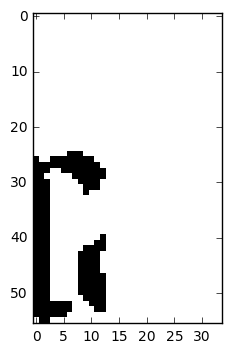

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 73.9045321941%
Elapsed time: 0.09900069236755371
---
 
Pipeline 2
Bad cut with a confidence of 93.9722537994%
Elapsed time: 0.005998849868774414
---
 
Pipeline 3
Good cut with a confidence of 73.9045321941% by letter 's_mediana'
Good cut corresponding to letter 's_alta' with a confidence of 96.5020775795%
Good cut corresponding to letter 'l' with a confidence of 2.11977027357%
Good cut corresponding to letter 'b' with a confidence of 1.09856454656%
Elapsed time: 0.10000061988830566
---
 
Pipeline 4
Bad cut with a confidence of 93.9722537994%
Elapsed time: 0.005999565124511719
---
 
---------
 
Cut number  19


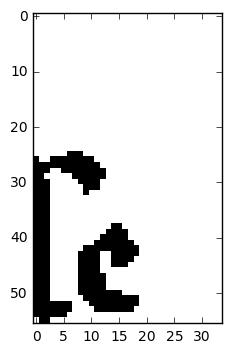

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 89.9214625359%
Elapsed time: 0.09999728202819824
---
 
Pipeline 2
Bad cut with a confidence of 99.818867445%
Elapsed time: 0.006000518798828125
---
 
Pipeline 3
Good cut with a confidence of 89.9214625359% by letter 's_mediana'
Good cut corresponding to letter 's_alta' with a confidence of 51.0477721691%
Good cut corresponding to letter 'f' with a confidence of 37.660202384%
Good cut corresponding to letter 'b' with a confidence of 10.9953857958%
Elapsed time: 0.10300040245056152
---
 
Pipeline 4
Bad cut with a confidence of 99.818867445%
Elapsed time: 0.00599980354309082
---
 
---------
 
Cut number  20


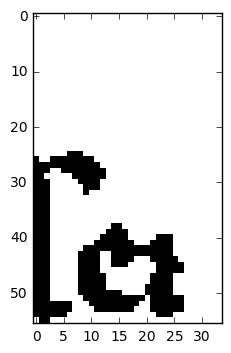

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 87.7847492695%
Elapsed time: 0.0950016975402832
---
 
Pipeline 2
Bad cut with a confidence of 99.9999821186%
Elapsed time: 0.00699925422668457
---
 
Pipeline 3
Good cut with a confidence of 87.7847492695% by letter 's_mediana'
Good cut corresponding to letter 'f' with a confidence of 73.719483614%
Good cut corresponding to letter 'b' with a confidence of 25.7357299328%
Good cut corresponding to letter 's_alta' with a confidence of 0.462650926784%
Elapsed time: 0.09400153160095215
---
 
Pipeline 4
Bad cut with a confidence of 99.9999821186%
Elapsed time: 0.005997657775878906
---
 
---------
 
Cut number  21


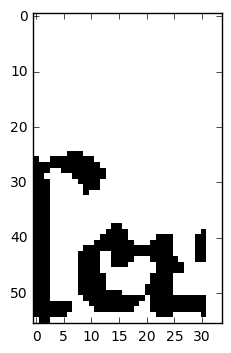

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 93.6158776283%
Elapsed time: 0.0970003604888916
---
 
Pipeline 2
Bad cut with a confidence of 100.0%
Elapsed time: 0.005999088287353516
---
 
Pipeline 3
Good cut with a confidence of 93.6158776283% by letter 's_mediana'
Good cut corresponding to letter 'f' with a confidence of 77.1894097328%
Good cut corresponding to letter 'b' with a confidence of 22.3007008433%
Good cut corresponding to letter 'd_alta' with a confidence of 0.279303453863%
Elapsed time: 0.10199999809265137
---
 
Pipeline 4
Bad cut with a confidence of 100.0%
Elapsed time: 0.00700068473815918
---
 
---------
 
Cut number  22


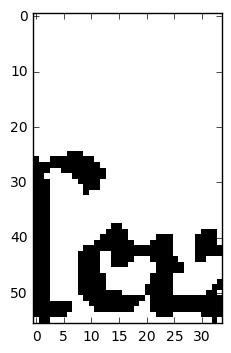

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 97.6334869862%
Elapsed time: 0.10799980163574219
---
 
Pipeline 2
Bad cut with a confidence of 100.0%
Elapsed time: 0.0060002803802490234
---
 
Pipeline 3
Good cut with a confidence of 97.6334869862% by letter 's_mediana'
Good cut corresponding to letter 'f' with a confidence of 77.8990626335%
Good cut corresponding to letter 'b' with a confidence of 21.9693854451%
Good cut corresponding to letter 'd_alta' with a confidence of 0.127925665583%
Elapsed time: 0.09799957275390625
---
 
Pipeline 4
Bad cut with a confidence of 100.0%
Elapsed time: 0.006000518798828125
---
 
---------
 
Cut number  23


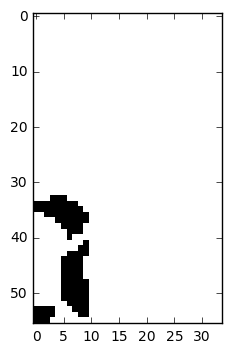

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 92.0853614807%
Elapsed time: 0.10399818420410156
---
 
Pipeline 2
Bad cut with a confidence of 99.8897433281%
Elapsed time: 0.005998373031616211
---
 
Pipeline 3
Good cut with a confidence of 92.0853614807% by letter 's_mediana'
Good cut corresponding to letter 'i' with a confidence of 81.9678962231%
Good cut corresponding to letter 'l' with a confidence of 17.2863274813%
Good cut corresponding to letter 's_alta' with a confidence of 0.678170705214%
Elapsed time: 0.10200309753417969
---
 
Pipeline 4
Bad cut with a confidence of 99.8897433281%
Elapsed time: 0.005996227264404297
---
 
---------
 
Cut number  24


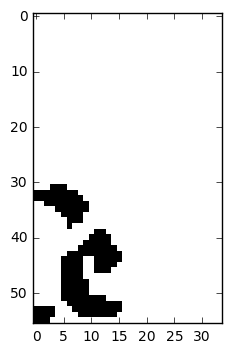

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 56.0509383678%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.6501088142%
Elapsed time: 0.09800601005554199
---
 
Pipeline 2
Bad cut with a confidence of 91.1653876305%
Elapsed time: 0.005994558334350586
---
 
Pipeline 3
Good cut with a confidence of 56.0509383678% by letter 'c'
Good cut with a confidence of 99.6501088142% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 89.1092479229%
Good cut corresponding to letter 's_bassa' with a confidence of 10.1889237761%
Good cut corresponding to letter 'a' with a confidence of 0.564244901761%
Elapsed time: 0.09999966621398926
---
 
Pipeline 4
Bad cut with a confidence of 91.1653876305%
Elapsed time: 0.005002260208129883
---
 
---------
 
Cut number  25


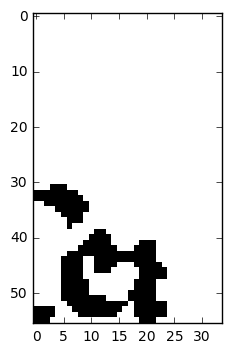

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.7915744781%
Elapsed time: 0.10199594497680664
---
 
Pipeline 2
Bad cut with a confidence of 99.9600589275%
Elapsed time: 0.007002353668212891
---
 
Pipeline 3
Good cut with a confidence of 99.7915744781% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 82.6085925102%
Good cut corresponding to letter 's_mediana' with a confidence of 13.2203012705%
Good cut corresponding to letter 'a' with a confidence of 4.01861146092%
Elapsed time: 0.1119990348815918
---
 
Pipeline 4
Bad cut with a confidence of 99.9600589275%
Elapsed time: 0.005998849868774414
---
 
---------
 
Cut number  26


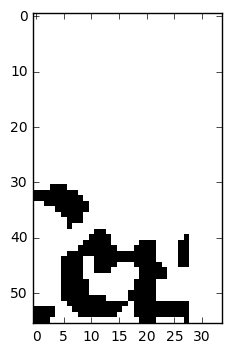

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.7123122215%
Elapsed time: 0.10500049591064453
---
 
Pipeline 2
Bad cut with a confidence of 99.9988257885%
Elapsed time: 0.006002187728881836
---
 
Pipeline 3
Good cut with a confidence of 99.7123122215% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 96.6811776161%
Good cut corresponding to letter 's_mediana' with a confidence of 2.88789067417%
Good cut corresponding to letter 'a' with a confidence of 0.226109405048%
Elapsed time: 0.10199832916259766
---
 
Pipeline 4
Bad cut with a confidence of 99.9988257885%
Elapsed time: 0.00500178337097168
---
 
---------
 
Cut number  27


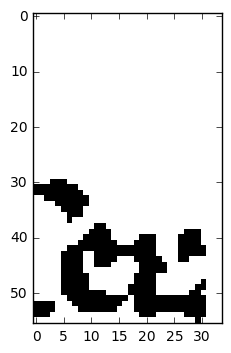

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 63.7165606022%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.7476935387%
Elapsed time: 0.09499645233154297
---
 
Pipeline 2
Bad cut with a confidence of 99.9997317791%
Elapsed time: 0.0049991607666015625
---
 
Pipeline 3
Good cut with a confidence of 63.7165606022% by letter 'a'
Good cut with a confidence of 99.7476935387% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.4585812092%
Good cut corresponding to letter 'b' with a confidence of 0.294422591105%
Good cut corresponding to letter 's_mediana' with a confidence of 0.206856359728%
Elapsed time: 0.10499858856201172
---
 
Pipeline 4
Bad cut with a confidence of 99.9997317791%
Elapsed time: 0.006000995635986328
---
 
---------
 
Cut number  28


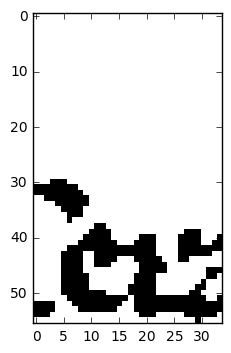

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 62.051063776%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.6665179729%
Elapsed time: 0.09599971771240234
---
 
Pipeline 2
Bad cut with a confidence of 100.0%
Elapsed time: 0.006001949310302734
---
 
Pipeline 3
Good cut with a confidence of 62.051063776% by letter 'a'
Good cut with a confidence of 99.6665179729% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.3233680725%
Good cut corresponding to letter 'b' with a confidence of 0.57397922501%
Good cut corresponding to letter 's_mediana' with a confidence of 0.0532944046427%
Elapsed time: 0.1009979248046875
---
 
Pipeline 4
Bad cut with a confidence of 100.0%
Elapsed time: 0.006000041961669922
---
 
---------
 
Cut number  29


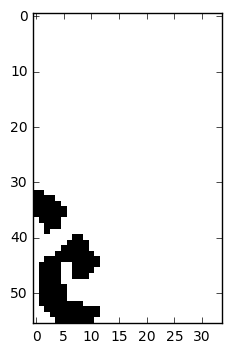

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 56.3488662243%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.3657708168%
Elapsed time: 0.09700512886047363
---
 
Pipeline 2
Bad cut with a confidence of 98.4025120735%
Elapsed time: 0.006994485855102539
---
 
Pipeline 3
Good cut with a confidence of 56.3488662243% by letter 'c'
Good cut with a confidence of 99.3657708168% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 55.4241836071%
Good cut corresponding to letter 's_bassa' with a confidence of 40.9926831722%
Good cut corresponding to letter 'c' with a confidence of 2.98888422549%
Elapsed time: 0.10500001907348633
---
 
Pipeline 4
Bad cut with a confidence of 98.4025120735%
Elapsed time: 0.00599980354309082
---
 
---------
 
Cut number  30


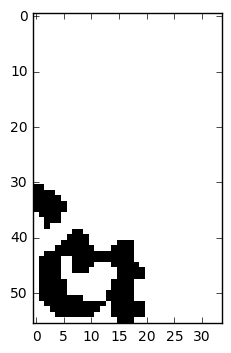

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 76.1560738087%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8959720135%
Elapsed time: 0.1009988784790039
---
 
Pipeline 2
Bad cut with a confidence of 99.1738200188%
Elapsed time: 0.0049991607666015625
---
 
Pipeline 3
Good cut with a confidence of 76.1560738087% by letter 'c'
Good cut with a confidence of 99.8959720135% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 98.7128257751%
Good cut corresponding to letter 's_mediana' with a confidence of 1.10903903842%
Good cut corresponding to letter 's_bassa' with a confidence of 0.132794177625%
Elapsed time: 0.10300111770629883
---
 
Pipeline 4
Bad cut with a confidence of 99.1738200188%
Elapsed time: 0.0060007572174072266
---
 
---------
 
Cut number  31


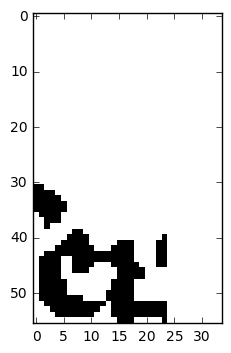

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8357176781%
Elapsed time: 0.0989987850189209
---
 
Pipeline 2
Bad cut with a confidence of 99.6010184288%
Elapsed time: 0.005999326705932617
---
 
Pipeline 3
Good cut with a confidence of 99.8357176781% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.7528910637%
Good cut corresponding to letter 's_mediana' with a confidence of 0.163674261421%
Good cut corresponding to letter 'b' with a confidence of 0.0459572591353%
Elapsed time: 0.09500312805175781
---
 
Pipeline 4
Bad cut with a confidence of 99.6010184288%
Elapsed time: 0.005997657775878906
---
 
---------
 
Cut number  32


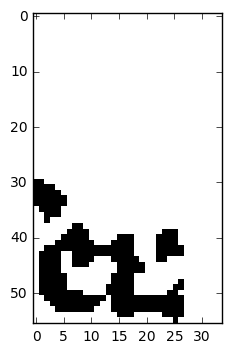

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8436748981%
Elapsed time: 0.09700155258178711
---
 
Pipeline 2
Bad cut with a confidence of 99.8592495918%
Elapsed time: 0.0060002803802490234
---
 
Pipeline 3
Good cut with a confidence of 99.8436748981% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.217414856%
Good cut corresponding to letter 'b' with a confidence of 0.660394132137%
Good cut corresponding to letter 's_mediana' with a confidence of 0.065917376196%
Elapsed time: 0.0989990234375
---
 
Pipeline 4
Bad cut with a confidence of 99.8592495918%
Elapsed time: 0.005999088287353516
---
 
---------
 
Cut number  33


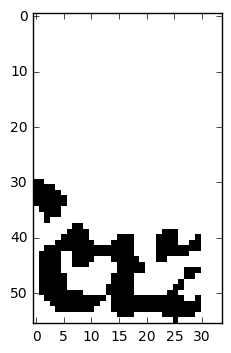

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8129665852%
Elapsed time: 0.0989980697631836
---
 
Pipeline 2
Bad cut with a confidence of 99.998652935%
Elapsed time: 0.004998445510864258
---
 
Pipeline 3
Good cut with a confidence of 99.8129665852% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.3268370628%
Good cut corresponding to letter 'b' with a confidence of 0.529540423304%
Good cut corresponding to letter 's_mediana' with a confidence of 0.104346650187%
Elapsed time: 0.10000205039978027
---
 
Pipeline 4
Bad cut with a confidence of 99.998652935%
Elapsed time: 0.0059986114501953125
---
 
---------
 
Cut number  34


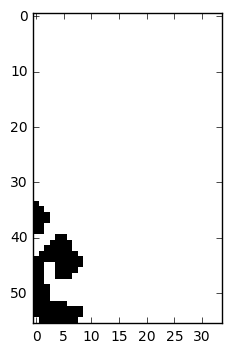

Pipeline 1
Bad cut
Elapsed time: 0.09700155258178711
---
 
Pipeline 2
Bad cut with a confidence of 99.9396681786%
Elapsed time: 0.006998538970947266
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09599876403808594
---
 
Pipeline 4
Bad cut with a confidence of 99.9396681786%
Elapsed time: 0.0050013065338134766
---
 
---------
 
Cut number  35


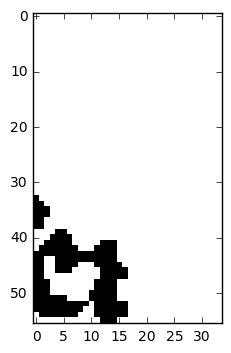

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 87.8520488739%
Elapsed time: 0.09599924087524414
---
 
Pipeline 2
Bad cut with a confidence of 55.7626545429%
Elapsed time: 0.00500035285949707
---
 
Pipeline 3
Good cut with a confidence of 87.8520488739% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 75.728559494%
Good cut corresponding to letter 'o' with a confidence of 15.0963842869%
Good cut corresponding to letter 'e' with a confidence of 2.70400438458%
Elapsed time: 0.09600257873535156
---
 
Pipeline 4
Bad cut with a confidence of 55.7626545429%
Elapsed time: 0.0049970149993896484
---
 
---------
 
Cut number  36


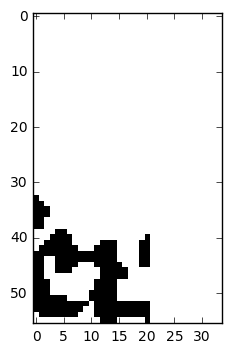

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 81.5950095654%
Elapsed time: 0.10000491142272949
---
 
Pipeline 2
Bad cut with a confidence of 86.1839294434%
Elapsed time: 0.005001544952392578
---
 
Pipeline 3
Good cut with a confidence of 81.5950095654% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 70.0541675091%
Good cut corresponding to letter 'e' with a confidence of 21.3084056973%
Good cut corresponding to letter 'o' with a confidence of 2.89677325636%
Elapsed time: 0.10199809074401855
---
 
Pipeline 4
Bad cut with a confidence of 86.1839294434%
Elapsed time: 0.0070018768310546875
---
 
---------
 
Cut number  37


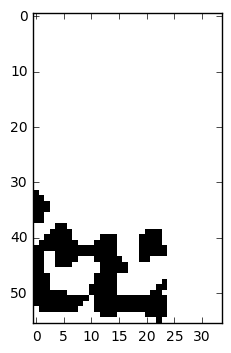

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 61.7842197418%
Elapsed time: 0.09900045394897461
---
 
Pipeline 2
Bad cut with a confidence of 94.6588516235%
Elapsed time: 0.005998849868774414
---
 
Pipeline 3
Good cut with a confidence of 61.7842197418% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 81.1497032642%
Good cut corresponding to letter 'b' with a confidence of 11.5928567946%
Good cut corresponding to letter 'e' with a confidence of 5.10808750987%
Elapsed time: 0.09599995613098145
---
 
Pipeline 4
Bad cut with a confidence of 94.6588516235%
Elapsed time: 0.005002498626708984
---
 
---------
 
Cut number  38


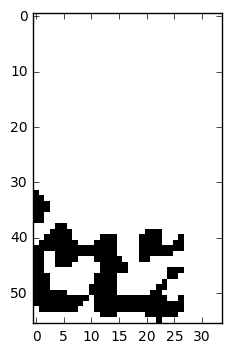

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 72.4799752235%
Elapsed time: 0.09399914741516113
---
 
Pipeline 2
Bad cut with a confidence of 97.7864921093%
Elapsed time: 0.006001710891723633
---
 
Pipeline 3
Good cut with a confidence of 72.4799752235% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 72.3539233208%
Good cut corresponding to letter 'e' with a confidence of 13.9739990234%
Good cut corresponding to letter 'b' with a confidence of 7.75241553783%
Elapsed time: 0.10399818420410156
---
 
Pipeline 4
Bad cut with a confidence of 97.7864921093%
Elapsed time: 0.0070002079010009766
---
 
---------
 
Cut number  39


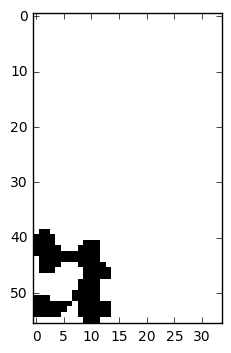

Pipeline 1
Bad cut
Elapsed time: 0.09999799728393555
---
 
Pipeline 2
Bad cut with a confidence of 90.3648376465%
Elapsed time: 0.00500035285949707
---
 
Pipeline 3
Bad cut
Elapsed time: 0.10399937629699707
---
 
Pipeline 4
Bad cut with a confidence of 90.3648376465%
Elapsed time: 0.006001472473144531
---
 
---------
 
Cut number  40


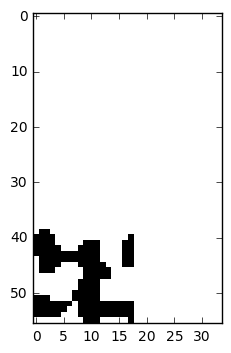

Pipeline 1
Bad cut
Elapsed time: 0.09799718856811523
---
 
Pipeline 2
Good cut corresponding to letter 'a' with a confidence of 45.1216042042%
Good cut corresponding to letter 'n' with a confidence of 30.6073755026%
Good cut corresponding to letter 'r' with a confidence of 17.475810647%
Elapsed time: 0.0110015869140625
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09299969673156738
---
 
Pipeline 4
Elapsed time: 0.09999871253967285
---
 
---------
 
Cut number  41


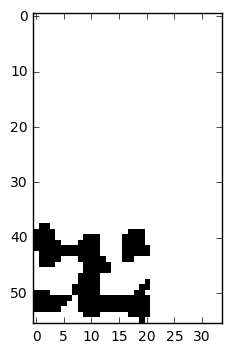

Pipeline 1
Bad cut
Elapsed time: 0.09599757194519043
---
 
Pipeline 2
Good cut corresponding to letter 'd_mediana' with a confidence of 46.5505301952%
Good cut corresponding to letter 'n' with a confidence of 28.0581474304%
Good cut corresponding to letter 'a' with a confidence of 20.945584774%
Elapsed time: 0.011999368667602539
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09600305557250977
---
 
Pipeline 4
Elapsed time: 0.09999728202819824
---
 
---------
 
Cut number  42


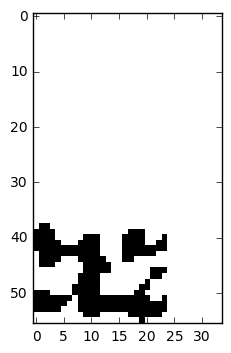

Pipeline 1
Bad cut
Elapsed time: 0.10199952125549316
---
 
Pipeline 2
Good cut corresponding to letter 'm' with a confidence of 53.9883971214%
Good cut corresponding to letter 'd_mediana' with a confidence of 36.199131608%
Good cut corresponding to letter 'a' with a confidence of 5.77687323093%
Elapsed time: 0.01199960708618164
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09600210189819336
---
 
Pipeline 4
Elapsed time: 0.0989999771118164
---
 
---------
 
Cut number  43


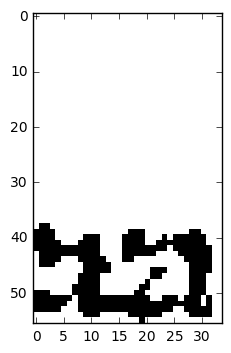

Pipeline 1
Bad cut
Elapsed time: 0.09600019454956055
---
 
Pipeline 2
Bad cut with a confidence of 98.6077129841%
Elapsed time: 0.0059969425201416016
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09299969673156738
---
 
Pipeline 4
Bad cut with a confidence of 98.6077129841%
Elapsed time: 0.006001472473144531
---
 
---------
 
Cut number  44


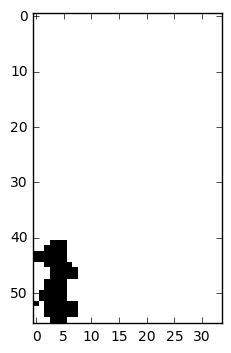

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 63.8097405434%
Elapsed time: 0.09300065040588379
---
 
Pipeline 2
Bad cut with a confidence of 96.2987542152%
Elapsed time: 0.004998683929443359
---
 
Pipeline 3
Good cut with a confidence of 63.8097405434% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 98.9646315575%
Good cut corresponding to letter 'a' with a confidence of 0.963040720671%
Good cut corresponding to letter 'e' with a confidence of 0.0288611481665%
Elapsed time: 0.09800124168395996
---
 
Pipeline 4
Bad cut with a confidence of 96.2987542152%
Elapsed time: 0.006000995635986328
---
 
---------
 
Cut number  45


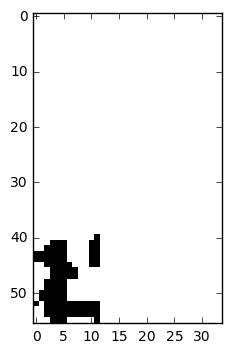

Pipeline 1
Bad cut
Elapsed time: 0.09999966621398926
---
 
Pipeline 2
Bad cut with a confidence of 94.2185759544%
Elapsed time: 0.006001949310302734
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09099912643432617
---
 
Pipeline 4
Bad cut with a confidence of 94.2185759544%
Elapsed time: 0.0059986114501953125
---
 
---------
 
Cut number  46


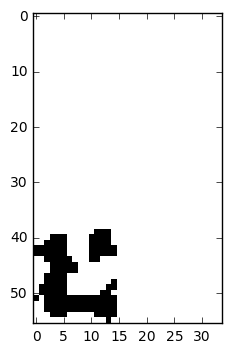

Pipeline 1
Cut 1 has been classified as good corresponding to char 'r' with a confidence of 97.1790134907%
Elapsed time: 0.10099649429321289
---
 
Pipeline 2
Good cut corresponding to letter 'r' with a confidence of 99.9954104424%
Good cut corresponding to letter 'i' with a confidence of 0.00224546656682%
Good cut corresponding to letter 'e' with a confidence of 0.00175908553501%
Elapsed time: 0.012000560760498047
---
 
Pipeline 3
Good cut with a confidence of 97.1790134907% by letter 'r'
Good cut corresponding to letter 'r' with a confidence of 99.9954104424%
Good cut corresponding to letter 'i' with a confidence of 0.00224546656682%
Good cut corresponding to letter 'e' with a confidence of 0.00175908553501%
Elapsed time: 0.10100340843200684
---
 
Pipeline 4
Good cut with a confidence of 97.1790134907% by letter 'r'
Elapsed time: 0.10099959373474121
---
 
---------
 
Cut number  47


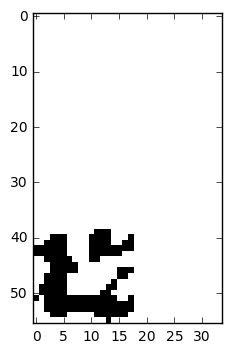

Pipeline 1
Cut 1 has been classified as good corresponding to char 'r' with a confidence of 51.3768613338%
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 52.0203769207%
Elapsed time: 0.09600090980529785
---
 
Pipeline 2
Good cut corresponding to letter 'r' with a confidence of 97.1575856209%
Good cut corresponding to letter 'u' with a confidence of 1.91810596734%
Good cut corresponding to letter 'a' with a confidence of 0.856765266508%
Elapsed time: 0.012999773025512695
---
 
Pipeline 3
Good cut with a confidence of 51.3768613338% by letter 'r'
Good cut with a confidence of 52.0203769207% by letter 'u'
Good cut corresponding to letter 'r' with a confidence of 97.1575856209%
Good cut corresponding to letter 'u' with a confidence of 1.91810596734%
Good cut corresponding to letter 'a' with a confidence of 0.856765266508%
Elapsed time: 0.10000181198120117
---
 
Pipeline 4
Good cut with a confidence of 51.3768613338% by letter 'r'
Good cut with a confidence

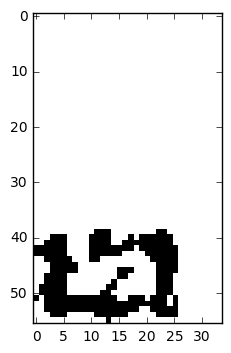

Pipeline 1
Bad cut
Elapsed time: 0.09799575805664062
---
 
Pipeline 2
Bad cut with a confidence of 94.1286563873%
Elapsed time: 0.006000041961669922
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09800004959106445
---
 
Pipeline 4
Bad cut with a confidence of 94.1286563873%
Elapsed time: 0.00600123405456543
---
 
---------
 
Cut number  49


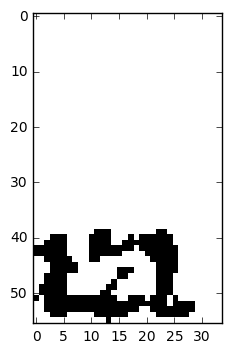

Pipeline 1
Bad cut
Elapsed time: 0.09699821472167969
---
 
Pipeline 2
Bad cut with a confidence of 94.1286563873%
Elapsed time: 0.0060002803802490234
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09599971771240234
---
 
Pipeline 4
Bad cut with a confidence of 94.1286563873%
Elapsed time: 0.0050008296966552734
---
 
---------
 
Cut number  50


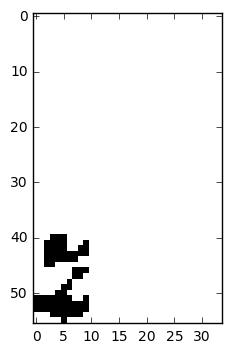

Pipeline 1
Bad cut
Elapsed time: 0.09899592399597168
---
 
Pipeline 2
Bad cut with a confidence of 99.5078384876%
Elapsed time: 0.006003379821777344
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09399724006652832
---
 
Pipeline 4
Bad cut with a confidence of 99.5078384876%
Elapsed time: 0.005002260208129883
---
 
---------
 
Cut number  51


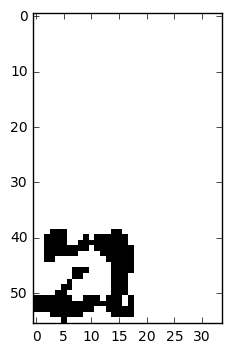

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 89.8184478283%
Elapsed time: 0.1029958724975586
---
 
Pipeline 2
Good cut corresponding to letter 'a' with a confidence of 99.697971344%
Good cut corresponding to letter 'e' with a confidence of 0.239045242779%
Good cut corresponding to letter 'n' with a confidence of 0.0542366527952%
Elapsed time: 0.012000322341918945
---
 
Pipeline 3
Good cut with a confidence of 89.8184478283% by letter 'a'
Good cut corresponding to letter 'a' with a confidence of 99.697971344%
Good cut corresponding to letter 'e' with a confidence of 0.239045242779%
Good cut corresponding to letter 'n' with a confidence of 0.0542366527952%
Elapsed time: 0.09900236129760742
---
 
Pipeline 4
Good cut with a confidence of 89.8184478283% by letter 'a'
Elapsed time: 0.10899972915649414
---
 
---------
 
Cut number  52


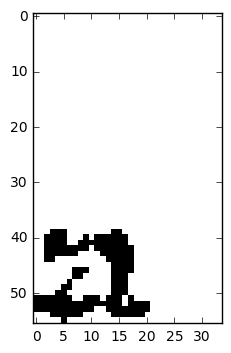

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 89.8184478283%
Elapsed time: 0.10699582099914551
---
 
Pipeline 2
Good cut corresponding to letter 'a' with a confidence of 99.697971344%
Good cut corresponding to letter 'e' with a confidence of 0.239045242779%
Good cut corresponding to letter 'n' with a confidence of 0.0542366527952%
Elapsed time: 0.01100015640258789
---
 
Pipeline 3
Good cut with a confidence of 89.8184478283% by letter 'a'
Good cut corresponding to letter 'a' with a confidence of 99.697971344%
Good cut corresponding to letter 'e' with a confidence of 0.239045242779%
Good cut corresponding to letter 'n' with a confidence of 0.0542366527952%
Elapsed time: 0.10499978065490723
---
 
Pipeline 4
Good cut with a confidence of 89.8184478283% by letter 'a'
Elapsed time: 0.10000014305114746
---
 
---------
 
Cut number  53


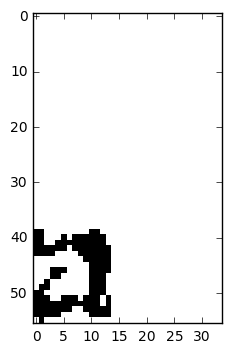

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 96.9940662384%
Elapsed time: 0.0970005989074707
---
 
Pipeline 2
Good cut corresponding to letter 'a' with a confidence of 99.8028099537%
Good cut corresponding to letter 'o' with a confidence of 0.072965270374%
Good cut corresponding to letter 'n' with a confidence of 0.0725722056814%
Elapsed time: 0.011000394821166992
---
 
Pipeline 3
Good cut with a confidence of 96.9940662384% by letter 'a'
Good cut corresponding to letter 'a' with a confidence of 99.8028099537%
Good cut corresponding to letter 'o' with a confidence of 0.072965270374%
Good cut corresponding to letter 'n' with a confidence of 0.0725722056814%
Elapsed time: 0.10699892044067383
---
 
Pipeline 4
Good cut with a confidence of 96.9940662384% by letter 'a'
Elapsed time: 0.10800051689147949
---
 
---------
 
Cut number  54


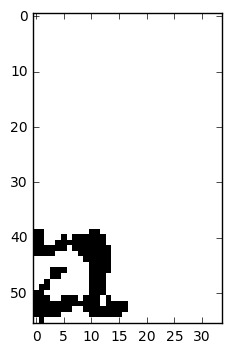

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 96.9940662384%
Elapsed time: 0.0989995002746582
---
 
Pipeline 2
Good cut corresponding to letter 'a' with a confidence of 99.8028099537%
Good cut corresponding to letter 'o' with a confidence of 0.072965270374%
Good cut corresponding to letter 'n' with a confidence of 0.0725722056814%
Elapsed time: 0.01199960708618164
---
 
Pipeline 3
Good cut with a confidence of 96.9940662384% by letter 'a'
Good cut corresponding to letter 'a' with a confidence of 99.8028099537%
Good cut corresponding to letter 'o' with a confidence of 0.072965270374%
Good cut corresponding to letter 'n' with a confidence of 0.0725722056814%
Elapsed time: 0.10300159454345703
---
 
Pipeline 4
Good cut with a confidence of 96.9940662384% by letter 'a'
Elapsed time: 0.1119990348815918
---
 
---------
 
Cut number  55


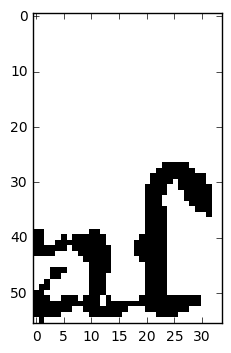

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 51.9908547401%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 96.3951230049%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 54.4943094254%
Elapsed time: 0.10599946975708008
---
 
Pipeline 2
Bad cut with a confidence of 99.9971568584%
Elapsed time: 0.005998373031616211
---
 
Pipeline 3
Good cut with a confidence of 51.9908547401% by letter 'a'
Good cut with a confidence of 96.3951230049% by letter 's_mediana'
Good cut with a confidence of 54.4943094254% by letter 'f'
Good cut corresponding to letter 'f' with a confidence of 86.6579353809%
Good cut corresponding to letter 's_alta' with a confidence of 9.18013453484%
Good cut corresponding to letter 'g' with a confidence of 4.05558571219%
Elapsed time: 0.11400079727172852
---
 
Pipeline 4
Bad cut with a confidence of 99.9971568584%
Elapsed time: 0.0059986114501953125
---
 


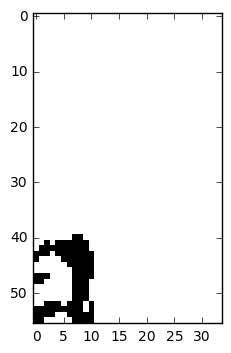

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 76.5595793724%
Elapsed time: 0.09999895095825195
---
 
Pipeline 2
Good cut corresponding to letter 'a' with a confidence of 72.2149193287%
Good cut corresponding to letter 'o' with a confidence of 16.1387816072%
Good cut corresponding to letter 'e' with a confidence of 10.921575129%
Elapsed time: 0.012001514434814453
---
 
Pipeline 3
Good cut with a confidence of 76.5595793724% by letter 'a'
Good cut corresponding to letter 'a' with a confidence of 72.2149193287%
Good cut corresponding to letter 'o' with a confidence of 16.1387816072%
Good cut corresponding to letter 'e' with a confidence of 10.921575129%
Elapsed time: 0.09999966621398926
---
 
Pipeline 4
Good cut with a confidence of 76.5595793724% by letter 'a'
Elapsed time: 0.10299921035766602
---
 
---------
 
Cut number  57


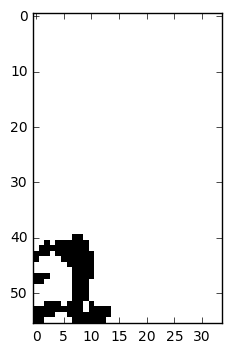

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 76.5595793724%
Elapsed time: 0.11499905586242676
---
 
Pipeline 2
Good cut corresponding to letter 'a' with a confidence of 72.2149193287%
Good cut corresponding to letter 'o' with a confidence of 16.1387816072%
Good cut corresponding to letter 'e' with a confidence of 10.921575129%
Elapsed time: 0.01300048828125
---
 
Pipeline 3
Good cut with a confidence of 76.5595793724% by letter 'a'
Good cut corresponding to letter 'a' with a confidence of 72.2149193287%
Good cut corresponding to letter 'o' with a confidence of 16.1387816072%
Good cut corresponding to letter 'e' with a confidence of 10.921575129%
Elapsed time: 0.10800027847290039
---
 
Pipeline 4
Good cut with a confidence of 76.5595793724% by letter 'a'
Elapsed time: 0.11200070381164551
---
 
---------
 
Cut number  58


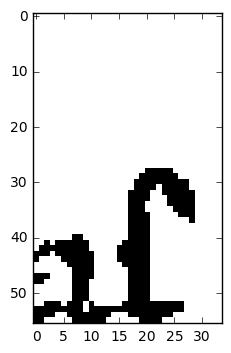

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 94.6475625038%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 76.5338540077%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 60.1361632347%
Cut 1 has been classified as good corresponding to char 's_bassa' with a confidence of 52.6006579399%
Elapsed time: 0.1029977798461914
---
 
Pipeline 2
Bad cut with a confidence of 99.994623661%
Elapsed time: 0.00500035285949707
---
 
Pipeline 3
Good cut with a confidence of 94.6475625038% by letter 's_mediana'
Good cut with a confidence of 76.5338540077% by letter 's_alta'
Good cut with a confidence of 60.1361632347% by letter 'f'
Good cut with a confidence of 52.6006579399% by letter 's_bassa'
Good cut corresponding to letter 's_alta' with a confidence of 74.7356414795%
Good cut corresponding to letter 'f' with a confidence of 19.9697136879%
Good cut corresponding to letter 'g'

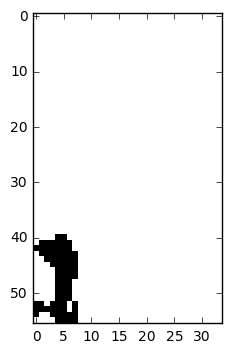

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 85.861158371%
Elapsed time: 0.11299920082092285
---
 
Pipeline 2
Bad cut with a confidence of 87.5600516796%
Elapsed time: 0.008002519607543945
---
 
Pipeline 3
Good cut with a confidence of 85.861158371% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9830901623%
Good cut corresponding to letter 'a' with a confidence of 0.012630065612%
Good cut corresponding to letter 't' with a confidence of 0.00228470216825%
Elapsed time: 0.13399457931518555
---
 
Pipeline 4
Bad cut with a confidence of 87.5600516796%
Elapsed time: 0.00800180435180664
---
 
---------
 
Cut number  60


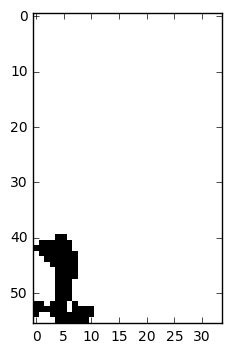

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 85.861158371%
Elapsed time: 0.13399934768676758
---
 
Pipeline 2
Bad cut with a confidence of 87.5600516796%
Elapsed time: 0.007001399993896484
---
 
Pipeline 3
Good cut with a confidence of 85.861158371% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9830901623%
Good cut corresponding to letter 'a' with a confidence of 0.012630065612%
Good cut corresponding to letter 't' with a confidence of 0.00228470216825%
Elapsed time: 0.13099980354309082
---
 
Pipeline 4
Bad cut with a confidence of 87.5600516796%
Elapsed time: 0.006001472473144531
---
 
---------
 
Cut number  61


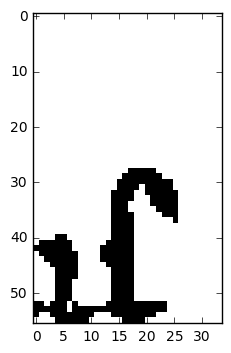

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 88.1184279919%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 82.8540682793%
Elapsed time: 0.12099981307983398
---
 
Pipeline 2
Bad cut with a confidence of 79.0483236313%
Elapsed time: 0.007000923156738281
---
 
Pipeline 3
Good cut with a confidence of 88.1184279919% by letter 's_mediana'
Good cut with a confidence of 82.8540682793% by letter 's_alta'
Good cut corresponding to letter 's_alta' with a confidence of 91.1402106285%
Good cut corresponding to letter 'f' with a confidence of 8.41357558966%
Good cut corresponding to letter 's_bassa' with a confidence of 0.316358101554%
Elapsed time: 0.11900019645690918
---
 
Pipeline 4
Bad cut with a confidence of 79.0483236313%
Elapsed time: 0.005999088287353516
---
 
---------
 
Cut number  62


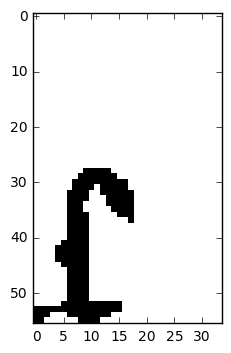

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 87.8506839275%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 98.9912807941%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 74.3447065353%
Elapsed time: 0.10900044441223145
---
 
Pipeline 2
Good cut corresponding to letter 's_alta' with a confidence of 98.554289341%
Good cut corresponding to letter 'f' with a confidence of 1.44541487098%
Good cut corresponding to letter 'l' with a confidence of 0.000266100232693%
Elapsed time: 0.010999679565429688
---
 
Pipeline 3
Good cut with a confidence of 87.8506839275% by letter 's_mediana'
Good cut with a confidence of 98.9912807941% by letter 's_alta'
Good cut with a confidence of 74.3447065353% by letter 'f'
Good cut corresponding to letter 's_alta' with a confidence of 98.554289341%
Good cut corresponding to letter 'f' with a confidence of 1.44541487098%
Good cut correspon

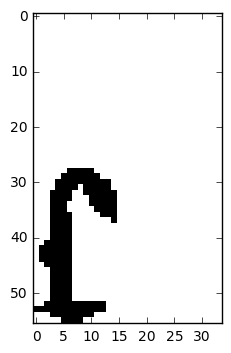

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 93.1297600269%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 98.3947098255%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 81.9280147552%
Elapsed time: 0.11599898338317871
---
 
Pipeline 2
Good cut corresponding to letter 's_alta' with a confidence of 99.6038615704%
Good cut corresponding to letter 'f' with a confidence of 0.395517982543%
Good cut corresponding to letter 'l' with a confidence of 0.000462572461402%
Elapsed time: 0.013001203536987305
---
 
Pipeline 3
Good cut with a confidence of 93.1297600269% by letter 's_mediana'
Good cut with a confidence of 98.3947098255% by letter 's_alta'
Good cut with a confidence of 81.9280147552% by letter 'f'
Good cut corresponding to letter 's_alta' with a confidence of 99.6038615704%
Good cut corresponding to letter 'f' with a confidence of 0.395517982543%
Good cut corre

In [11]:
for i in range(0,len(cuts)):
    print("Cut number ", i+1)
    u.plot_image(cuts[i], (img_cols, img_rows))
    print("Pipeline 1")
    predict_pipeline1([cuts[i]], count_letter=False)
    print("Pipeline 2")
    predict_pipeline2([cuts[i]], count_letter=False)
    print("Pipeline 3")
    predict_pipeline3([cuts[i]], count_letter=False)
    print("Pipeline 4")
    predict_pipeline4([cuts[i]], count_letter=False)
    print("---------")
    print(" ")

### "Beneficiu"

Examples: 


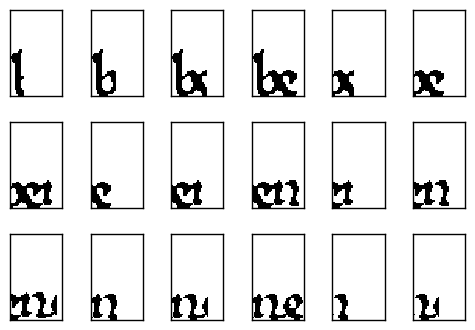

In [12]:
files = []
folders = []
for (path, dirnames, filenames) in os.walk(os.path.join('not_code',os.path.join('word_segments','beneficiu'))):
    folders.extend(os.path.join(path, name) for name in dirnames)
    files.extend(os.path.join(path, name) for name in filenames)

files.sort(key=natural_keys)

cuts = iu.open_many_samples(files)
(cuts, _) = kiu.adjust_input(np.asarray(cuts))

print ("Examples: ")
u.plot_some_images(cuts[:18], (img_cols, img_rows), grid_x=6, grid_y=3)

Cut number  1


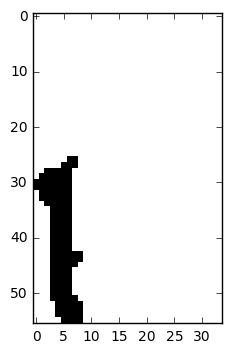

Pipeline 1
Cut 1 has been classified as good corresponding to char 'h' with a confidence of 60.8471989632%
Cut 1 has been classified as good corresponding to char 'l' with a confidence of 99.6506989002%
Elapsed time: 0.09499716758728027
---
 
Pipeline 2
Bad cut with a confidence of 58.5582613945%
Elapsed time: 0.0060007572174072266
---
 
Pipeline 3
Good cut with a confidence of 60.8471989632% by letter 'h'
Good cut with a confidence of 99.6506989002% by letter 'l'
Good cut corresponding to letter 'l' with a confidence of 100.0%
Good cut corresponding to letter 's_alta' with a confidence of 2.84290280206e-06%
Good cut corresponding to letter 'h' with a confidence of 1.99698063641e-08%
Elapsed time: 0.10900068283081055
---
 
Pipeline 4
Bad cut with a confidence of 58.5582613945%
Elapsed time: 0.006000518798828125
---
 
---------
 
Cut number  2


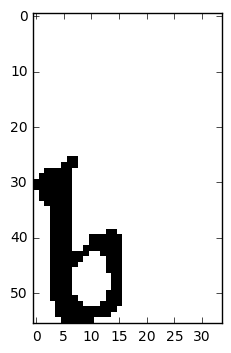

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 51.0967135429%
Cut 1 has been classified as good corresponding to char 'b' with a confidence of 93.6722099781%
Cut 1 has been classified as good corresponding to char 'h' with a confidence of 92.6204562187%
Elapsed time: 0.10200190544128418
---
 
Pipeline 2
Good cut corresponding to letter 'b' with a confidence of 98.9981293678%
Good cut corresponding to letter 'h' with a confidence of 1.00171891972%
Good cut corresponding to letter 'l' with a confidence of 0.000152263055497%
Elapsed time: 0.012998104095458984
---
 
Pipeline 3
Good cut with a confidence of 51.0967135429% by letter 's_mediana'
Good cut with a confidence of 93.6722099781% by letter 'b'
Good cut with a confidence of 92.6204562187% by letter 'h'
Good cut corresponding to letter 'b' with a confidence of 98.9981293678%
Good cut corresponding to letter 'h' with a confidence of 1.00171891972%
Good cut corresponding to letter 'l'

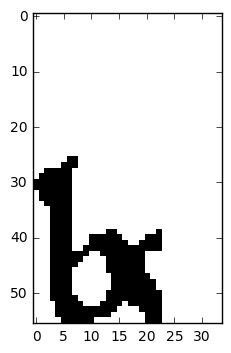

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 68.1338787079%
Cut 1 has been classified as good corresponding to char 'b' with a confidence of 91.4488971233%
Cut 1 has been classified as good corresponding to char 'h' with a confidence of 80.4587483406%
Elapsed time: 0.10299921035766602
---
 
Pipeline 2
Good cut corresponding to letter 'b' with a confidence of 93.8926100731%
Good cut corresponding to letter 'h' with a confidence of 6.10685870051%
Good cut corresponding to letter 'f' with a confidence of 0.000526566554981%
Elapsed time: 0.012000560760498047
---
 
Pipeline 3
Good cut with a confidence of 68.1338787079% by letter 's_mediana'
Good cut with a confidence of 91.4488971233% by letter 'b'
Good cut with a confidence of 80.4587483406% by letter 'h'
Good cut corresponding to letter 'b' with a confidence of 93.8926100731%
Good cut corresponding to letter 'h' with a confidence of 6.10685870051%
Good cut corresponding to letter 'f'

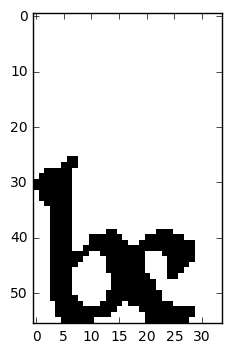

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 88.0842804909%
Cut 1 has been classified as good corresponding to char 'b' with a confidence of 83.0087065697%
Elapsed time: 0.10900020599365234
---
 
Pipeline 2
Bad cut with a confidence of 99.9996840954%
Elapsed time: 0.005999326705932617
---
 
Pipeline 3
Good cut with a confidence of 88.0842804909% by letter 's_mediana'
Good cut with a confidence of 83.0087065697% by letter 'b'
Good cut corresponding to letter 'b' with a confidence of 99.250459671%
Good cut corresponding to letter 'h' with a confidence of 0.748136267066%
Good cut corresponding to letter 'f' with a confidence of 0.00139842813951%
Elapsed time: 0.11099982261657715
---
 
Pipeline 4
Bad cut with a confidence of 99.9996840954%
Elapsed time: 0.0060007572174072266
---
 
---------
 
Cut number  5


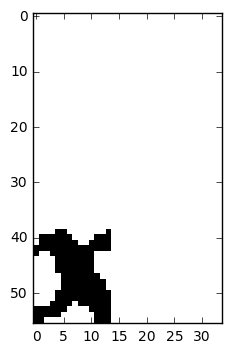

Pipeline 1
Cut 1 has been classified as good corresponding to char 'r' with a confidence of 94.2947566509%
Elapsed time: 0.10600137710571289
---
 
Pipeline 2
Bad cut with a confidence of 94.4881618023%
Elapsed time: 0.005999088287353516
---
 
Pipeline 3
Good cut with a confidence of 94.2947566509% by letter 'r'
Good cut corresponding to letter 'r' with a confidence of 97.9764640331%
Good cut corresponding to letter 'e' with a confidence of 1.24303195626%
Good cut corresponding to letter 'i' with a confidence of 0.403620442376%
Elapsed time: 0.10799956321716309
---
 
Pipeline 4
Bad cut with a confidence of 94.4881618023%
Elapsed time: 0.0070018768310546875
---
 
---------
 
Cut number  6


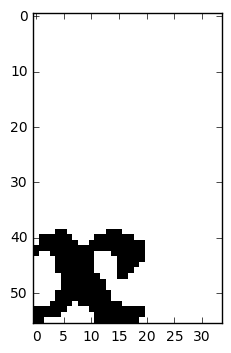

Pipeline 1
Cut 1 has been classified as good corresponding to char 'n' with a confidence of 78.4582018852%
Elapsed time: 0.1270003318786621
---
 
Pipeline 2
Bad cut with a confidence of 73.2225418091%
Elapsed time: 0.005998134613037109
---
 
Pipeline 3
Good cut with a confidence of 78.4582018852% by letter 'n'
Good cut corresponding to letter 'e' with a confidence of 50.2322971821%
Good cut corresponding to letter 'n' with a confidence of 49.3105351925%
Good cut corresponding to letter 'a' with a confidence of 0.426920875907%
Elapsed time: 0.10899972915649414
---
 
Pipeline 4
Bad cut with a confidence of 73.2225418091%
Elapsed time: 0.006001472473144531
---
 
---------
 
Cut number  7


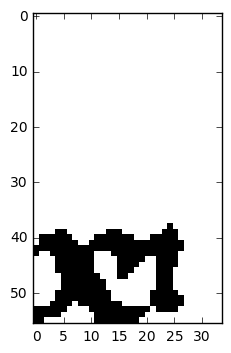

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 70.1458096504%
Elapsed time: 0.1230018138885498
---
 
Pipeline 2
Bad cut with a confidence of 99.1591572762%
Elapsed time: 0.005999565124511719
---
 
Pipeline 3
Good cut with a confidence of 70.1458096504% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 99.9999821186%
Good cut corresponding to letter 'e' with a confidence of 1.44678480751e-05%
Good cut corresponding to letter 'd_mediana' with a confidence of 3.14100887522e-06%
Elapsed time: 0.11999893188476562
---
 
Pipeline 4
Bad cut with a confidence of 99.1591572762%
Elapsed time: 0.008001089096069336
---
 
---------
 
Cut number  8


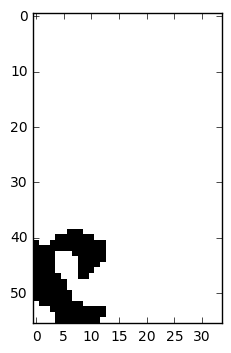

Pipeline 1
Cut 1 has been classified as good corresponding to char 'e' with a confidence of 99.3154227734%
Cut 1 has been classified as good corresponding to char 'o' with a confidence of 88.6422514915%
Elapsed time: 0.14399409294128418
---
 
Pipeline 2
Good cut corresponding to letter 'e' with a confidence of 99.9657154083%
Good cut corresponding to letter 'o' with a confidence of 0.0338424870279%
Good cut corresponding to letter 'c' with a confidence of 0.000425058669862%
Elapsed time: 0.013000726699829102
---
 
Pipeline 3
Good cut with a confidence of 99.3154227734% by letter 'e'
Good cut with a confidence of 88.6422514915% by letter 'o'
Good cut corresponding to letter 'e' with a confidence of 99.9657154083%
Good cut corresponding to letter 'o' with a confidence of 0.0338424870279%
Good cut corresponding to letter 'c' with a confidence of 0.000425058669862%
Elapsed time: 0.14699983596801758
---
 
Pipeline 4
Good cut with a confidence of 99.3154227734% by letter 'e'
Good cut with a 

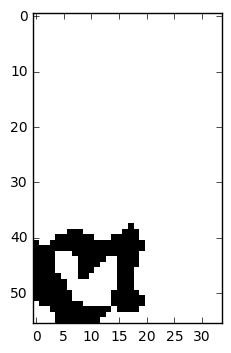

Pipeline 1
Bad cut
Elapsed time: 0.12199854850769043
---
 
Pipeline 2
Bad cut with a confidence of 99.9987900257%
Elapsed time: 0.007002115249633789
---
 
Pipeline 3
Bad cut
Elapsed time: 0.11299800872802734
---
 
Pipeline 4
Bad cut with a confidence of 99.9987900257%
Elapsed time: 0.0060002803802490234
---
 
---------
 
Cut number  10


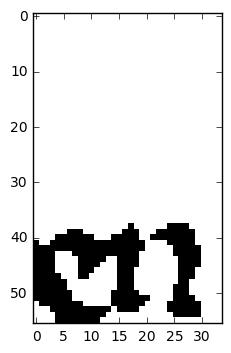

Pipeline 1
Bad cut
Elapsed time: 0.1159965991973877
---
 
Pipeline 2
Bad cut with a confidence of 99.9998927116%
Elapsed time: 0.005999565124511719
---
 
Pipeline 3
Bad cut
Elapsed time: 0.11500000953674316
---
 
Pipeline 4
Bad cut with a confidence of 99.9998927116%
Elapsed time: 0.007000446319580078
---
 
---------
 
Cut number  11


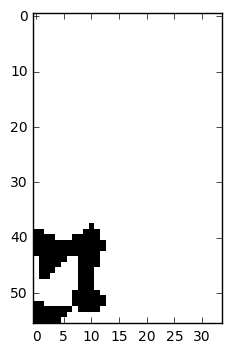

Pipeline 1
Bad cut
Elapsed time: 0.11299872398376465
---
 
Pipeline 2
Bad cut with a confidence of 75.1328349113%
Elapsed time: 0.005001544952392578
---
 
Pipeline 3
Bad cut
Elapsed time: 0.10099983215332031
---
 
Pipeline 4
Bad cut with a confidence of 75.1328349113%
Elapsed time: 0.007000446319580078
---
 
---------
 
Cut number  12


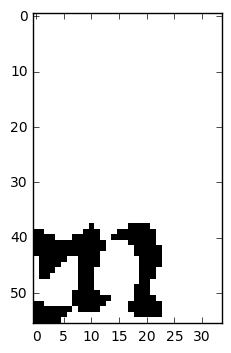

Pipeline 1
Bad cut
Elapsed time: 0.1679999828338623
---
 
Pipeline 2
Good cut corresponding to letter 'm' with a confidence of 99.9912261963%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.00576727506996%
Good cut corresponding to letter 'n' with a confidence of 0.00292599233944%
Elapsed time: 0.036002159118652344
---
 
Pipeline 3
Bad cut
Elapsed time: 0.17999863624572754
---
 
Pipeline 4
Elapsed time: 0.13199901580810547
---
 
---------
 
Cut number  13


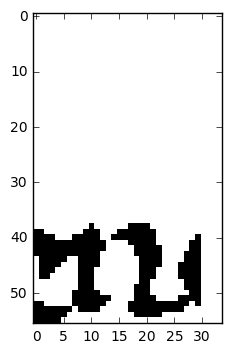

Pipeline 1
Bad cut
Elapsed time: 0.13499784469604492
---
 
Pipeline 2
Bad cut with a confidence of 97.9134380817%
Elapsed time: 0.005999565124511719
---
 
Pipeline 3
Bad cut
Elapsed time: 0.10300278663635254
---
 
Pipeline 4
Bad cut with a confidence of 97.9134380817%
Elapsed time: 0.006997346878051758
---
 
---------
 
Cut number  14


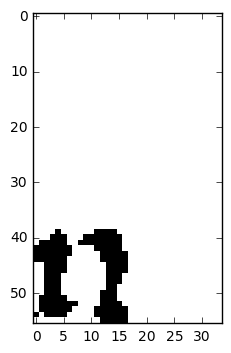

Pipeline 1
Cut 1 has been classified as good corresponding to char 'n' with a confidence of 84.061563015%
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 91.1552429199%
Elapsed time: 0.10399961471557617
---
 
Pipeline 2
Good cut corresponding to letter 'n' with a confidence of 82.6698601246%
Good cut corresponding to letter 'u' with a confidence of 17.2912359238%
Good cut corresponding to letter 'o' with a confidence of 0.0198313471628%
Elapsed time: 0.011000394821166992
---
 
Pipeline 3
Good cut with a confidence of 84.061563015% by letter 'n'
Good cut with a confidence of 91.1552429199% by letter 'u'
Good cut corresponding to letter 'n' with a confidence of 82.6698601246%
Good cut corresponding to letter 'u' with a confidence of 17.2912359238%
Good cut corresponding to letter 'o' with a confidence of 0.0198313471628%
Elapsed time: 0.2069997787475586
---
 
Pipeline 4
Good cut with a confidence of 84.061563015% by letter 'n'
Good cut with a confidence o

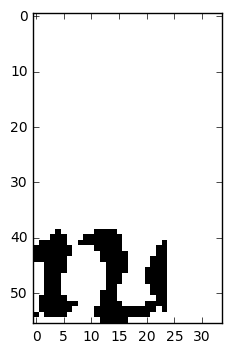

Pipeline 1
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 88.9518618584%
Elapsed time: 0.12600016593933105
---
 
Pipeline 2
Bad cut with a confidence of 62.4310314655%
Elapsed time: 0.005999565124511719
---
 
Pipeline 3
Good cut with a confidence of 88.9518618584% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 77.8157353401%
Good cut corresponding to letter 'n' with a confidence of 21.8611747026%
Good cut corresponding to letter 'a' with a confidence of 0.161394174211%
Elapsed time: 0.1250004768371582
---
 
Pipeline 4
Bad cut with a confidence of 62.4310314655%
Elapsed time: 0.005999088287353516
---
 
---------
 
Cut number  16


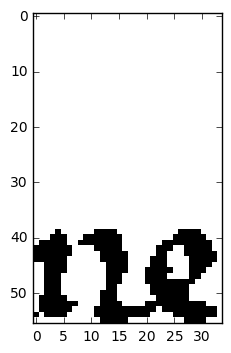

Pipeline 1
Bad cut
Elapsed time: 0.11400175094604492
---
 
Pipeline 2
Bad cut with a confidence of 99.9992549419%
Elapsed time: 0.0059986114501953125
---
 
Pipeline 3
Bad cut
Elapsed time: 0.11299991607666016
---
 
Pipeline 4
Bad cut with a confidence of 99.9992549419%
Elapsed time: 0.008000850677490234
---
 
---------
 
Cut number  17


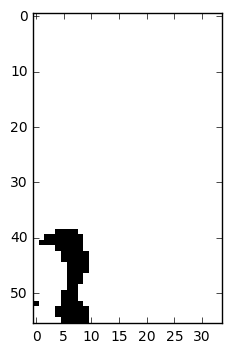

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 80.8413982391%
Elapsed time: 0.10200262069702148
---
 
Pipeline 2
Good cut corresponding to letter 'i' with a confidence of 99.9230742455%
Good cut corresponding to letter 'a' with a confidence of 0.0758777314331%
Good cut corresponding to letter 'l' with a confidence of 0.000426153746957%
Elapsed time: 0.012996435165405273
---
 
Pipeline 3
Good cut with a confidence of 80.8413982391% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9230742455%
Good cut corresponding to letter 'a' with a confidence of 0.0758777314331%
Good cut corresponding to letter 'l' with a confidence of 0.000426153746957%
Elapsed time: 0.11600232124328613
---
 
Pipeline 4
Good cut with a confidence of 80.8413982391% by letter 'i'
Elapsed time: 0.1139988899230957
---
 
---------
 
Cut number  18


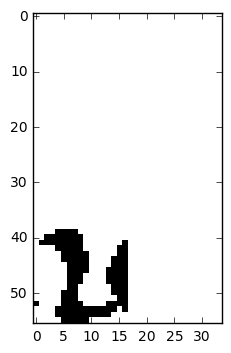

Pipeline 1
Bad cut
Elapsed time: 0.1029973030090332
---
 
Pipeline 2
Bad cut with a confidence of 82.9452812672%
Elapsed time: 0.0059986114501953125
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09700155258178711
---
 
Pipeline 4
Bad cut with a confidence of 82.9452812672%
Elapsed time: 0.00599980354309082
---
 
---------
 
Cut number  19


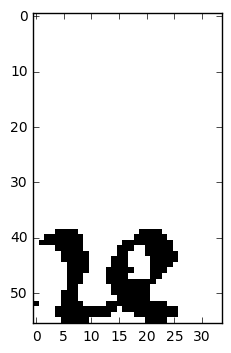

Pipeline 1
Bad cut
Elapsed time: 0.10599946975708008
---
 
Pipeline 2
Bad cut with a confidence of 99.1896629333%
Elapsed time: 0.005999326705932617
---
 
Pipeline 3
Bad cut
Elapsed time: 0.10400199890136719
---
 
Pipeline 4
Bad cut with a confidence of 99.1896629333%
Elapsed time: 0.005998373031616211
---
 
---------
 
Cut number  20


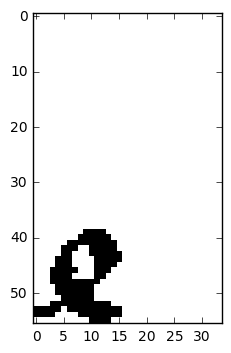

Pipeline 1
Cut 1 has been classified as good corresponding to char 'e' with a confidence of 97.0570921898%
Cut 1 has been classified as good corresponding to char 'o' with a confidence of 76.7404437065%
Elapsed time: 0.10200214385986328
---
 
Pipeline 2
Good cut corresponding to letter 'e' with a confidence of 99.9641597271%
Good cut corresponding to letter 'o' with a confidence of 0.0356198754162%
Good cut corresponding to letter 'c' with a confidence of 0.000166689312664%
Elapsed time: 0.012998819351196289
---
 
Pipeline 3
Good cut with a confidence of 97.0570921898% by letter 'e'
Good cut with a confidence of 76.7404437065% by letter 'o'
Good cut corresponding to letter 'e' with a confidence of 99.9641597271%
Good cut corresponding to letter 'o' with a confidence of 0.0356198754162%
Good cut corresponding to letter 'c' with a confidence of 0.000166689312664%
Elapsed time: 0.10899853706359863
---
 
Pipeline 4
Good cut with a confidence of 97.0570921898% by letter 'e'
Good cut with a 

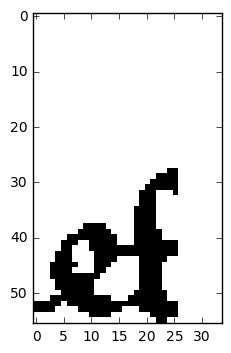

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.6474862099%
Elapsed time: 0.09699749946594238
---
 
Pipeline 2
Bad cut with a confidence of 99.9391078949%
Elapsed time: 0.006000041961669922
---
 
Pipeline 3
Good cut with a confidence of 99.6474862099% by letter 's_mediana'
Good cut corresponding to letter 'b' with a confidence of 56.4994215965%
Good cut corresponding to letter 'f' with a confidence of 42.69066751%
Good cut corresponding to letter 'd_alta' with a confidence of 0.641931593418%
Elapsed time: 0.10299944877624512
---
 
Pipeline 4
Bad cut with a confidence of 99.9391078949%
Elapsed time: 0.004999637603759766
---
 
---------
 
Cut number  22


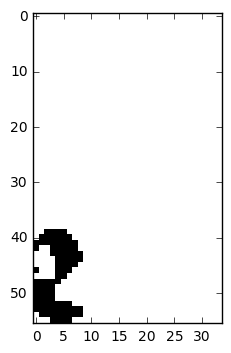

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 81.2135577202%
Elapsed time: 0.10299825668334961
---
 
Pipeline 2
Bad cut with a confidence of 91.0907387733%
Elapsed time: 0.00599980354309082
---
 
Pipeline 3
Good cut with a confidence of 81.2135577202% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9949455261%
Good cut corresponding to letter 'a' with a confidence of 0.0017002250388%
Good cut corresponding to letter 't' with a confidence of 0.00140380871017%
Elapsed time: 0.09600162506103516
---
 
Pipeline 4
Bad cut with a confidence of 91.0907387733%
Elapsed time: 0.005998373031616211
---
 
---------
 
Cut number  23


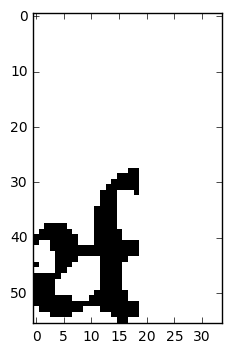

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 75.0319421291%
Elapsed time: 0.09599709510803223
---
 
Pipeline 2
Good cut corresponding to letter 'f' with a confidence of 67.1478867531%
Good cut corresponding to letter 'b' with a confidence of 27.9867649078%
Good cut corresponding to letter 'd_alta' with a confidence of 4.12062369287%
Elapsed time: 0.013000726699829102
---
 
Pipeline 3
Good cut with a confidence of 75.0319421291% by letter 's_mediana'
Good cut corresponding to letter 'f' with a confidence of 67.1478867531%
Good cut corresponding to letter 'b' with a confidence of 27.9867649078%
Good cut corresponding to letter 'd_alta' with a confidence of 4.12062369287%
Elapsed time: 0.10299873352050781
---
 
Pipeline 4
Good cut with a confidence of 75.0319421291% by letter 's_mediana'
Elapsed time: 0.09800148010253906
---
 
---------
 
Cut number  24


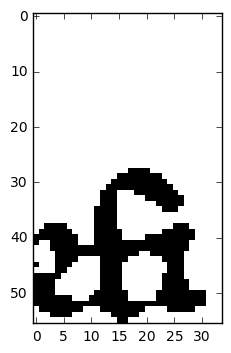

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.7964084148%
Elapsed time: 0.09199881553649902
---
 
Pipeline 2
Bad cut with a confidence of 100.0%
Elapsed time: 0.005999565124511719
---
 
Pipeline 3
Good cut with a confidence of 99.7964084148% by letter 's_mediana'
Good cut corresponding to letter 'f' with a confidence of 48.2659012079%
Good cut corresponding to letter 'g' with a confidence of 39.5535171032%
Good cut corresponding to letter 's_mediana' with a confidence of 6.06572106481%
Elapsed time: 0.09900116920471191
---
 
Pipeline 4
Bad cut with a confidence of 100.0%
Elapsed time: 0.005000114440917969
---
 
---------
 
Cut number  25


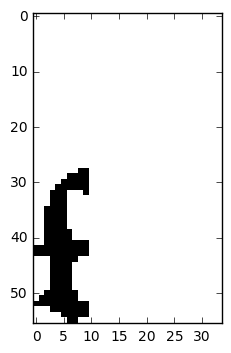

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 80.237865448%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 92.2410786152%
Elapsed time: 0.09499907493591309
---
 
Pipeline 2
Bad cut with a confidence of 76.0666072369%
Elapsed time: 0.005999565124511719
---
 
Pipeline 3
Good cut with a confidence of 80.237865448% by letter 's_mediana'
Good cut with a confidence of 92.2410786152% by letter 's_alta'
Good cut corresponding to letter 's_alta' with a confidence of 96.5045273304%
Good cut corresponding to letter 'l' with a confidence of 2.6464086026%
Good cut corresponding to letter 'f' with a confidence of 0.840328354388%
Elapsed time: 0.10000085830688477
---
 
Pipeline 4
Bad cut with a confidence of 76.0666072369%
Elapsed time: 0.005000114440917969
---
 
---------
 
Cut number  26


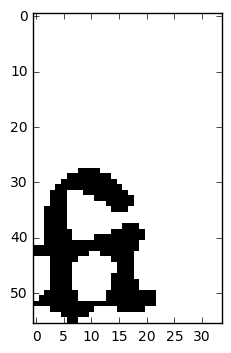

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8350143433%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 90.257871151%
Elapsed time: 0.09999632835388184
---
 
Pipeline 2
Good cut corresponding to letter 'f' with a confidence of 99.9757766724%
Good cut corresponding to letter 's_alta' with a confidence of 0.0241572299274%
Good cut corresponding to letter 'b' with a confidence of 4.61786157757e-05%
Elapsed time: 0.01300048828125
---
 
Pipeline 3
Good cut with a confidence of 99.8350143433% by letter 's_mediana'
Good cut with a confidence of 90.257871151% by letter 'f'
Good cut corresponding to letter 'f' with a confidence of 99.9757766724%
Good cut corresponding to letter 's_alta' with a confidence of 0.0241572299274%
Good cut corresponding to letter 'b' with a confidence of 4.61786157757e-05%
Elapsed time: 0.10900163650512695
---
 
Pipeline 4
Good cut with a confidence of 99.8350143433% by letter 

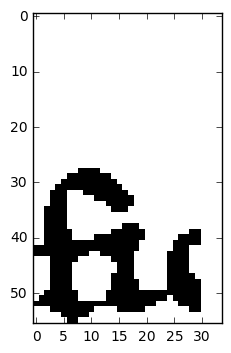

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8028159142%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 79.1291117668%
Elapsed time: 0.09500002861022949
---
 
Pipeline 2
Bad cut with a confidence of 99.9980330467%
Elapsed time: 0.00599980354309082
---
 
Pipeline 3
Good cut with a confidence of 99.8028159142% by letter 's_mediana'
Good cut with a confidence of 79.1291117668% by letter 'f'
Good cut corresponding to letter 'f' with a confidence of 99.9965369701%
Good cut corresponding to letter 's_bassa' with a confidence of 0.00221780610445%
Good cut corresponding to letter 'g' with a confidence of 0.000741294343243%
Elapsed time: 0.12100005149841309
---
 
Pipeline 4
Bad cut with a confidence of 99.9980330467%
Elapsed time: 0.0060002803802490234
---
 
---------
 
Cut number  28


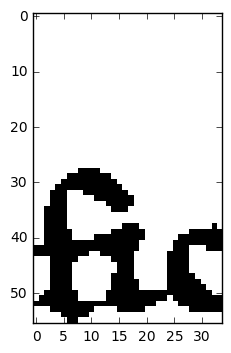

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.9263942242%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 82.8037440777%
Elapsed time: 0.09600019454956055
---
 
Pipeline 2
Bad cut with a confidence of 99.9999523163%
Elapsed time: 0.00599980354309082
---
 
Pipeline 3
Good cut with a confidence of 99.9263942242% by letter 's_mediana'
Good cut with a confidence of 82.8037440777% by letter 'f'
Good cut corresponding to letter 'f' with a confidence of 99.5854377747%
Good cut corresponding to letter 'g' with a confidence of 0.359400245361%
Good cut corresponding to letter 's_mediana' with a confidence of 0.0467565987492%
Elapsed time: 0.0989990234375
---
 
Pipeline 4
Bad cut with a confidence of 99.9999523163%
Elapsed time: 0.005002498626708984
---
 
---------
 
Cut number  29


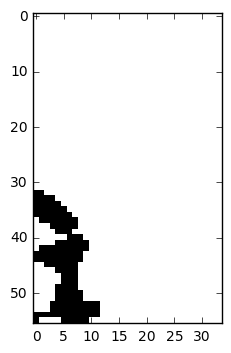

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 98.11668396%
Elapsed time: 0.1029970645904541
---
 
Pipeline 2
Bad cut with a confidence of 99.9732971191%
Elapsed time: 0.004999637603759766
---
 
Pipeline 3
Good cut with a confidence of 98.11668396% by letter 's_mediana'
Good cut corresponding to letter 'a' with a confidence of 51.6897797585%
Good cut corresponding to letter 's_alta' with a confidence of 25.3155887127%
Good cut corresponding to letter 'i' with a confidence of 20.567946136%
Elapsed time: 0.11899971961975098
---
 
Pipeline 4
Bad cut with a confidence of 99.9732971191%
Elapsed time: 0.006001710891723633
---
 
---------
 
Cut number  30


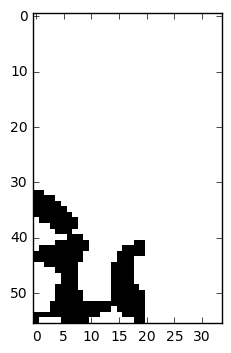

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 92.969161272%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 98.7561821938%
Elapsed time: 0.09599828720092773
---
 
Pipeline 2
Bad cut with a confidence of 99.916613102%
Elapsed time: 0.004999399185180664
---
 
Pipeline 3
Good cut with a confidence of 92.969161272% by letter 'a'
Good cut with a confidence of 98.7561821938% by letter 's_mediana'
Good cut corresponding to letter 'a' with a confidence of 89.8864090443%
Good cut corresponding to letter 'b' with a confidence of 4.49215136468%
Good cut corresponding to letter 's_mediana' with a confidence of 4.19486388564%
Elapsed time: 0.09999966621398926
---
 
Pipeline 4
Bad cut with a confidence of 99.916613102%
Elapsed time: 0.006000995635986328
---
 
---------
 
Cut number  31


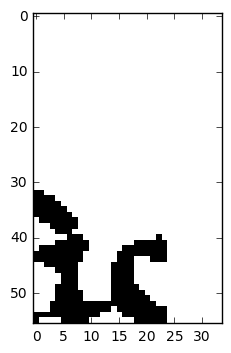

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 98.7301230431%
Elapsed time: 0.09499907493591309
---
 
Pipeline 2
Bad cut with a confidence of 99.9719619751%
Elapsed time: 0.00800013542175293
---
 
Pipeline 3
Good cut with a confidence of 98.7301230431% by letter 's_mediana'
Good cut corresponding to letter 's_mediana' with a confidence of 43.9434349537%
Good cut corresponding to letter 'd_alta' with a confidence of 24.5931178331%
Good cut corresponding to letter 'b' with a confidence of 12.8011673689%
Elapsed time: 0.09999895095825195
---
 
Pipeline 4
Bad cut with a confidence of 99.9719619751%
Elapsed time: 0.0060002803802490234
---
 
---------
 
Cut number  32


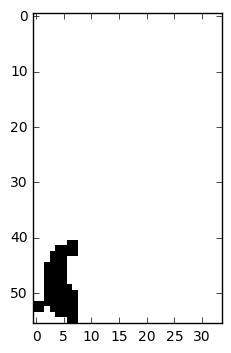

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 68.500483036%
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 61.9017362595%
Elapsed time: 0.10099911689758301
---
 
Pipeline 2
Bad cut with a confidence of 99.6383845806%
Elapsed time: 0.004999637603759766
---
 
Pipeline 3
Good cut with a confidence of 68.500483036% by letter 'c'
Good cut with a confidence of 61.9017362595% by letter 'i'
Good cut corresponding to letter 'c' with a confidence of 58.5436582565%
Good cut corresponding to letter 'i' with a confidence of 40.2144491673%
Good cut corresponding to letter 'e' with a confidence of 1.20851555839%
Elapsed time: 0.10400247573852539
---
 
Pipeline 4
Bad cut with a confidence of 99.6383845806%
Elapsed time: 0.005998134613037109
---
 
---------
 
Cut number  33


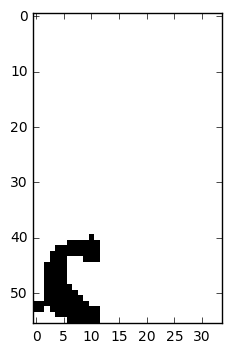

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 98.9584743977%
Elapsed time: 0.09499788284301758
---
 
Pipeline 2
Good cut corresponding to letter 'c' with a confidence of 99.9905288219%
Good cut corresponding to letter 'e' with a confidence of 0.0071529080742%
Good cut corresponding to letter 'o' with a confidence of 0.00198219240701%
Elapsed time: 0.013004779815673828
---
 
Pipeline 3
Good cut with a confidence of 98.9584743977% by letter 'c'
Good cut corresponding to letter 'c' with a confidence of 99.9905288219%
Good cut corresponding to letter 'e' with a confidence of 0.0071529080742%
Good cut corresponding to letter 'o' with a confidence of 0.00198219240701%
Elapsed time: 0.11499500274658203
---
 
Pipeline 4
Good cut with a confidence of 98.9584743977% by letter 'c'
Elapsed time: 0.11400127410888672
---
 
---------
 
Cut number  34


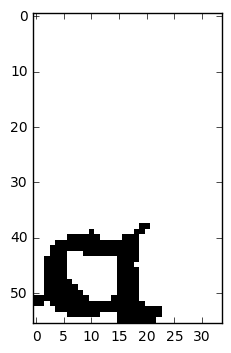

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 82.4158966541%
Elapsed time: 0.12299704551696777
---
 
Pipeline 2
Bad cut with a confidence of 99.9993979931%
Elapsed time: 0.0070002079010009766
---
 
Pipeline 3
Good cut with a confidence of 82.4158966541% by letter 'c'
Good cut corresponding to letter 'a' with a confidence of 74.7689843178%
Good cut corresponding to letter 'o' with a confidence of 21.5964630246%
Good cut corresponding to letter 'e' with a confidence of 1.8069980666%
Elapsed time: 0.11799955368041992
---
 
Pipeline 4
Bad cut with a confidence of 99.9993979931%
Elapsed time: 0.006001472473144531
---
 
---------
 
Cut number  35


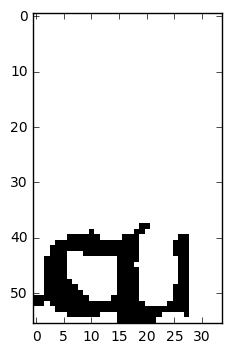

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 50.1191616058%
Elapsed time: 0.10399866104125977
---
 
Pipeline 2
Bad cut with a confidence of 99.9955356121%
Elapsed time: 0.005998134613037109
---
 
Pipeline 3
Good cut with a confidence of 50.1191616058% by letter 'c'
Good cut corresponding to letter 'n' with a confidence of 65.2360022068%
Good cut corresponding to letter 'o' with a confidence of 23.6074447632%
Good cut corresponding to letter 'u' with a confidence of 3.61333712935%
Elapsed time: 0.10200023651123047
---
 
Pipeline 4
Bad cut with a confidence of 99.9955356121%
Elapsed time: 0.0070035457611083984
---
 
---------
 
Cut number  36


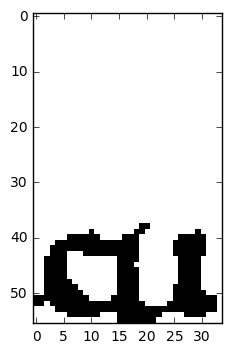

Pipeline 1
Bad cut
Elapsed time: 0.09599828720092773
---
 
Pipeline 2
Bad cut with a confidence of 99.9993622303%
Elapsed time: 0.006002187728881836
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09599757194519043
---
 
Pipeline 4
Bad cut with a confidence of 99.9993622303%
Elapsed time: 0.005000114440917969
---
 
---------
 
Cut number  37


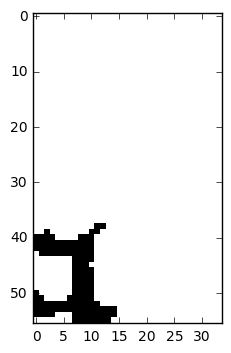

Pipeline 1
Bad cut
Elapsed time: 0.0969991683959961
---
 
Pipeline 2
Bad cut with a confidence of 99.8970627785%
Elapsed time: 0.007002830505371094
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09499621391296387
---
 
Pipeline 4
Bad cut with a confidence of 99.8970627785%
Elapsed time: 0.004999399185180664
---
 
---------
 
Cut number  38


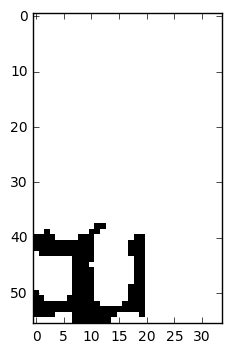

Pipeline 1
Bad cut
Elapsed time: 0.09399890899658203
---
 
Pipeline 2
Bad cut with a confidence of 89.4099116325%
Elapsed time: 0.005002498626708984
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09599804878234863
---
 
Pipeline 4
Bad cut with a confidence of 89.4099116325%
Elapsed time: 0.005002021789550781
---
 
---------
 
Cut number  39


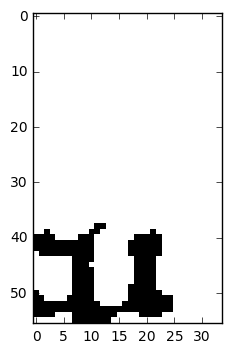

Pipeline 1
Bad cut
Elapsed time: 0.09399890899658203
---
 
Pipeline 2
Bad cut with a confidence of 99.8528003693%
Elapsed time: 0.005997896194458008
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09400010108947754
---
 
Pipeline 4
Bad cut with a confidence of 99.8528003693%
Elapsed time: 0.006001710891723633
---
 
---------
 
Cut number  40


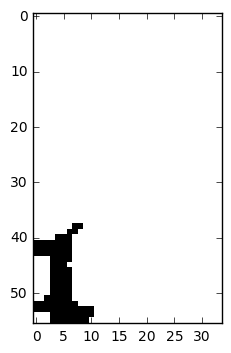

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 88.2022082806%
Elapsed time: 0.09999871253967285
---
 
Pipeline 2
Bad cut with a confidence of 72.3785281181%
Elapsed time: 0.006001710891723633
---
 
Pipeline 3
Good cut with a confidence of 88.2022082806% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9940037727%
Good cut corresponding to letter 't' with a confidence of 0.00354660805897%
Good cut corresponding to letter 'l' with a confidence of 0.00203346462513%
Elapsed time: 0.10199761390686035
---
 
Pipeline 4
Bad cut with a confidence of 72.3785281181%
Elapsed time: 0.006001472473144531
---
 
---------
 
Cut number  41


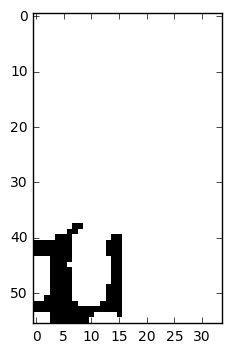

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 70.1352834702%
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 81.4704239368%
Elapsed time: 0.09600090980529785
---
 
Pipeline 2
Bad cut with a confidence of 57.7252745628%
Elapsed time: 0.005001068115234375
---
 
Pipeline 3
Good cut with a confidence of 70.1352834702% by letter 'i'
Good cut with a confidence of 81.4704239368% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 99.9918818474%
Good cut corresponding to letter 'i' with a confidence of 0.00325831897499%
Good cut corresponding to letter 'b' with a confidence of 0.00282632445305%
Elapsed time: 0.09699845314025879
---
 
Pipeline 4
Bad cut with a confidence of 57.7252745628%
Elapsed time: 0.004998683929443359
---
 
---------
 
Cut number  42


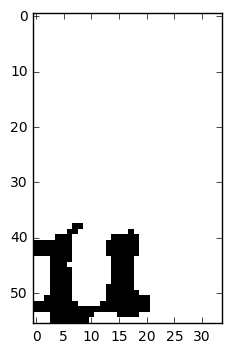

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 80.1703333855%
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 95.6447422504%
Elapsed time: 0.09499835968017578
---
 
Pipeline 2
Good cut corresponding to letter 'u' with a confidence of 99.999922514%
Good cut corresponding to letter 'n' with a confidence of 4.49129316848e-05%
Good cut corresponding to letter 'b' with a confidence of 2.27920367024e-05%
Elapsed time: 0.010998725891113281
---
 
Pipeline 3
Good cut with a confidence of 80.1703333855% by letter 'i'
Good cut with a confidence of 95.6447422504% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 99.999922514%
Good cut corresponding to letter 'n' with a confidence of 4.49129316848e-05%
Good cut corresponding to letter 'b' with a confidence of 2.27920367024e-05%
Elapsed time: 0.10000061988830566
---
 
Pipeline 4
Good cut with a confidence of 80.1703333855% by letter 'i'
Good cut with 

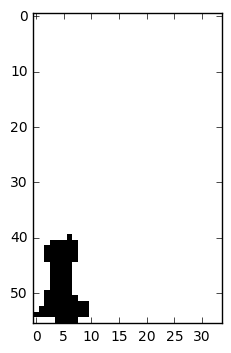

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 86.3861739635%
Elapsed time: 0.09400153160095215
---
 
Pipeline 2
Bad cut with a confidence of 85.0200772285%
Elapsed time: 0.004997968673706055
---
 
Pipeline 3
Good cut with a confidence of 86.3861739635% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9935626984%
Good cut corresponding to letter 't' with a confidence of 0.00364788902516%
Good cut corresponding to letter 'a' with a confidence of 0.00185239514394%
Elapsed time: 0.10199928283691406
---
 
Pipeline 4
Bad cut with a confidence of 85.0200772285%
Elapsed time: 0.006001949310302734
---
 
---------
 
Cut number  44


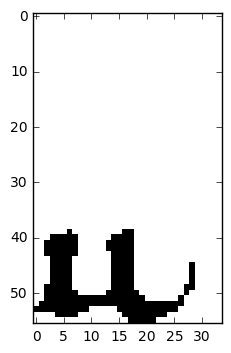

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 85.7198238373%
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 98.3821094036%
Cut 1 has been classified as good corresponding to char 'q' with a confidence of 52.9106259346%
Elapsed time: 0.09799885749816895
---
 
Pipeline 2
Good cut corresponding to letter 'u' with a confidence of 99.9993801117%
Good cut corresponding to letter 'n' with a confidence of 0.000609206699664%
Good cut corresponding to letter 'a' with a confidence of 7.86286165066e-06%
Elapsed time: 0.011998891830444336
---
 
Pipeline 3
Good cut with a confidence of 85.7198238373% by letter 'i'
Good cut with a confidence of 98.3821094036% by letter 'u'
Good cut with a confidence of 52.9106259346% by letter 'q'
Good cut corresponding to letter 'u' with a confidence of 99.9993801117%
Good cut corresponding to letter 'n' with a confidence of 0.000609206699664%
Good cut corresponding to letter 'a' with a 

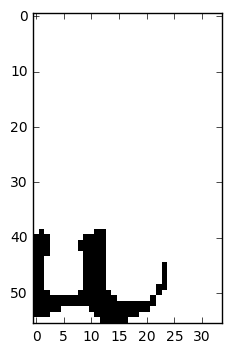

Pipeline 1
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 90.4062747955%
Elapsed time: 0.09499812126159668
---
 
Pipeline 2
Good cut corresponding to letter 'u' with a confidence of 99.9981403351%
Good cut corresponding to letter 'n' with a confidence of 0.00138661416713%
Good cut corresponding to letter 'a' with a confidence of 0.000358986289939%
Elapsed time: 0.012001276016235352
---
 
Pipeline 3
Good cut with a confidence of 90.4062747955% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 99.9981403351%
Good cut corresponding to letter 'n' with a confidence of 0.00138661416713%
Good cut corresponding to letter 'a' with a confidence of 0.000358986289939%
Elapsed time: 0.10199809074401855
---
 
Pipeline 4
Good cut with a confidence of 90.4062747955% by letter 'u'
Elapsed time: 0.10000014305114746
---
 
---------
 
Cut number  46


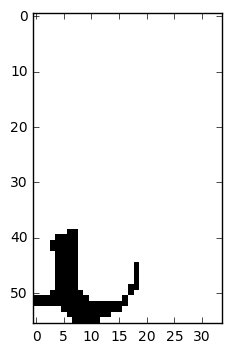

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 91.6479885578%
Elapsed time: 0.0969994068145752
---
 
Pipeline 2
Bad cut with a confidence of 67.1883821487%
Elapsed time: 0.004998207092285156
---
 
Pipeline 3
Good cut with a confidence of 91.6479885578% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9930202961%
Good cut corresponding to letter 't' with a confidence of 0.00459942457383%
Good cut corresponding to letter 'l' with a confidence of 0.00166754034581%
Elapsed time: 0.09799981117248535
---
 
Pipeline 4
Bad cut with a confidence of 67.1883821487%
Elapsed time: 0.0050013065338134766
---
 
---------
 


In [13]:
for i in range(0,len(cuts)):
    print("Cut number ", i+1)
    u.plot_image(cuts[i], (img_cols, img_rows))
    print("Pipeline 1")
    predict_pipeline1([cuts[i]], count_letter=False)
    print("Pipeline 2")
    predict_pipeline2([cuts[i]], count_letter=False)
    print("Pipeline 3")
    predict_pipeline3([cuts[i]], count_letter=False)
    print("Pipeline 4")
    predict_pipeline4([cuts[i]], count_letter=False)
    print("---------")
    print(" ")

### "unicu"

Examples: 


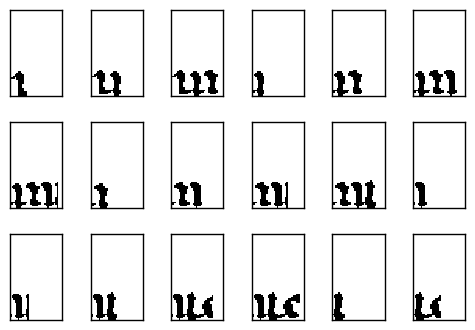

In [14]:
files = []
folders = []
for (path, dirnames, filenames) in os.walk(os.path.join('not_code',os.path.join('word_segments','unicu'))):
    folders.extend(os.path.join(path, name) for name in dirnames)
    files.extend(os.path.join(path, name) for name in filenames)

files.sort(key=natural_keys)

cuts = iu.open_many_samples(files)
(cuts, _) = kiu.adjust_input(np.asarray(cuts))

print ("Examples: ")
u.plot_some_images(cuts[:18], (img_cols, img_rows), grid_x=6, grid_y=3)

Cut number  1


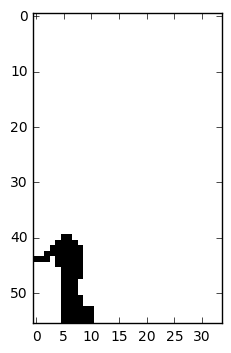

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 71.7354953289%
Elapsed time: 0.0989987850189209
---
 
Pipeline 2
Bad cut with a confidence of 69.7740256786%
Elapsed time: 0.00600123405456543
---
 
Pipeline 3
Good cut with a confidence of 71.7354953289% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.8878955841%
Good cut corresponding to letter 'a' with a confidence of 0.078113732161%
Good cut corresponding to letter 't' with a confidence of 0.0168769067386%
Elapsed time: 0.09999895095825195
---
 
Pipeline 4
Bad cut with a confidence of 69.7740256786%
Elapsed time: 0.006000995635986328
---
 
---------
 
Cut number  2


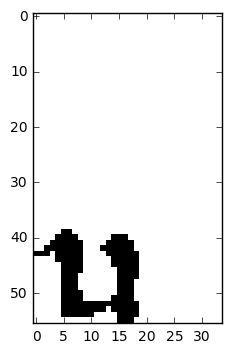

Pipeline 1
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 96.2721705437%
Elapsed time: 0.10100078582763672
---
 
Pipeline 2
Good cut corresponding to letter 'u' with a confidence of 99.8230576515%
Good cut corresponding to letter 'n' with a confidence of 0.176916550845%
Good cut corresponding to letter 'a' with a confidence of 3.09267193188e-05%
Elapsed time: 0.010998725891113281
---
 
Pipeline 3
Good cut with a confidence of 96.2721705437% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 99.8230576515%
Good cut corresponding to letter 'n' with a confidence of 0.176916550845%
Good cut corresponding to letter 'a' with a confidence of 3.09267193188e-05%
Elapsed time: 0.10100102424621582
---
 
Pipeline 4
Good cut with a confidence of 96.2721705437% by letter 'u'
Elapsed time: 0.09699821472167969
---
 
---------
 
Cut number  3


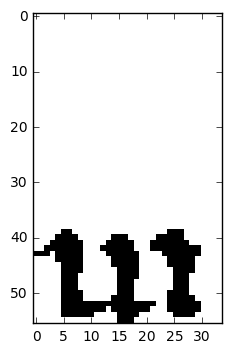

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 74.8233675957%
Elapsed time: 0.09099960327148438
---
 
Pipeline 2
Bad cut with a confidence of 99.8972594738%
Elapsed time: 0.006000041961669922
---
 
Pipeline 3
Good cut with a confidence of 74.8233675957% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 99.9999403954%
Good cut corresponding to letter 'n' with a confidence of 6.27266274478e-05%
Good cut corresponding to letter 'e' with a confidence of 1.73933911718e-07%
Elapsed time: 0.09599924087524414
---
 
Pipeline 4
Bad cut with a confidence of 99.8972594738%
Elapsed time: 0.006000041961669922
---
 
---------
 
Cut number  4


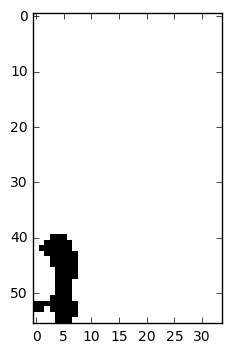

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 88.4264826775%
Elapsed time: 0.09699869155883789
---
 
Pipeline 2
Bad cut with a confidence of 84.0145111084%
Elapsed time: 0.005997180938720703
---
 
Pipeline 3
Good cut with a confidence of 88.4264826775% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9898135662%
Good cut corresponding to letter 'a' with a confidence of 0.00751756379032%
Good cut corresponding to letter 't' with a confidence of 0.00154942790687%
Elapsed time: 0.10000061988830566
---
 
Pipeline 4
Bad cut with a confidence of 84.0145111084%
Elapsed time: 0.0049991607666015625
---
 
---------
 
Cut number  5


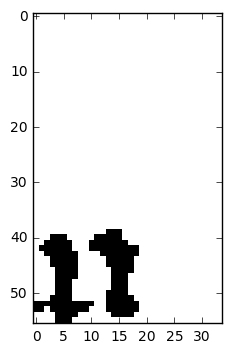

Pipeline 1
Cut 1 has been classified as good corresponding to char 'n' with a confidence of 75.6693780422%
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 85.0533306599%
Elapsed time: 0.1100010871887207
---
 
Pipeline 2
Bad cut with a confidence of 68.84739995%
Elapsed time: 0.0059986114501953125
---
 
Pipeline 3
Good cut with a confidence of 75.6693780422% by letter 'n'
Good cut with a confidence of 85.0533306599% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 62.0046496391%
Good cut corresponding to letter 'n' with a confidence of 37.9933208227%
Good cut corresponding to letter 'o' with a confidence of 0.00177785568667%
Elapsed time: 0.10299992561340332
---
 
Pipeline 4
Bad cut with a confidence of 68.84739995%
Elapsed time: 0.005000591278076172
---
 
---------
 
Cut number  6


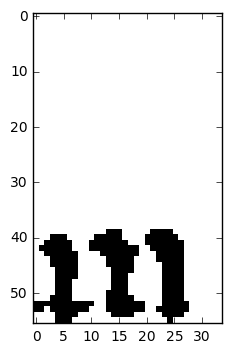

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 96.6629624367%
Elapsed time: 0.09600114822387695
---
 
Pipeline 2
Good cut corresponding to letter 'm' with a confidence of 100.0%
Good cut corresponding to letter 'n' with a confidence of 7.55860511958e-06%
Good cut corresponding to letter 'e' with a confidence of 3.15709847154e-08%
Elapsed time: 0.010998964309692383
---
 
Pipeline 3
Good cut with a confidence of 96.6629624367% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 100.0%
Good cut corresponding to letter 'n' with a confidence of 7.55860511958e-06%
Good cut corresponding to letter 'e' with a confidence of 3.15709847154e-08%
Elapsed time: 0.0989997386932373
---
 
Pipeline 4
Good cut with a confidence of 96.6629624367% by letter 'm'
Elapsed time: 0.09999966621398926
---
 
---------
 
Cut number  7


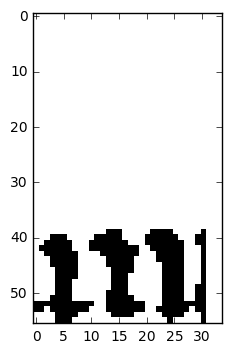

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 82.5164437294%
Elapsed time: 0.09399724006652832
---
 
Pipeline 2
Bad cut with a confidence of 74.882209301%
Elapsed time: 0.005999088287353516
---
 
Pipeline 3
Good cut with a confidence of 82.5164437294% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 100.0%
Good cut corresponding to letter 'n' with a confidence of 1.87013804442e-07%
Good cut corresponding to letter 'd_mediana' with a confidence of 6.38444075385e-08%
Elapsed time: 0.10000181198120117
---
 
Pipeline 4
Bad cut with a confidence of 74.882209301%
Elapsed time: 0.004998922348022461
---
 
---------
 
Cut number  8


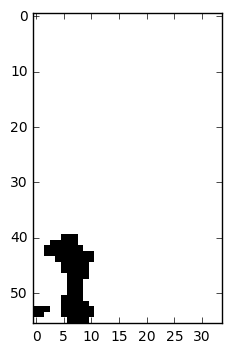

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 71.9534695148%
Elapsed time: 0.11300086975097656
---
 
Pipeline 2
Bad cut with a confidence of 91.8643832207%
Elapsed time: 0.005999326705932617
---
 
Pipeline 3
Good cut with a confidence of 71.9534695148% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.7251331806%
Good cut corresponding to letter 'a' with a confidence of 0.265648728237%
Good cut corresponding to letter 't' with a confidence of 0.00533289967279%
Elapsed time: 0.10199904441833496
---
 
Pipeline 4
Bad cut with a confidence of 91.8643832207%
Elapsed time: 0.006000518798828125
---
 
---------
 
Cut number  9


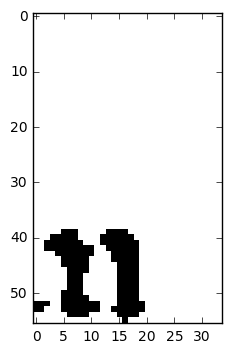

Pipeline 1
Cut 1 has been classified as good corresponding to char 'n' with a confidence of 98.4792530537%
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 77.37814188%
Elapsed time: 0.11299872398376465
---
 
Pipeline 2
Good cut corresponding to letter 'n' with a confidence of 98.8542079926%
Good cut corresponding to letter 'u' with a confidence of 1.14487390965%
Good cut corresponding to letter 'o' with a confidence of 0.000572804447074%
Elapsed time: 0.011999845504760742
---
 
Pipeline 3
Good cut with a confidence of 98.4792530537% by letter 'n'
Good cut with a confidence of 77.37814188% by letter 'u'
Good cut corresponding to letter 'n' with a confidence of 98.8542079926%
Good cut corresponding to letter 'u' with a confidence of 1.14487390965%
Good cut corresponding to letter 'o' with a confidence of 0.000572804447074%
Elapsed time: 0.09800124168395996
---
 
Pipeline 4
Good cut with a confidence of 98.4792530537% by letter 'n'
Good cut with a confiden

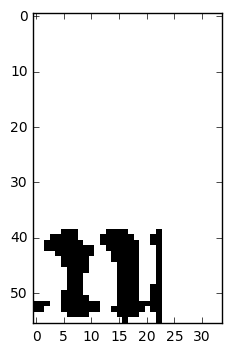

Pipeline 1
Cut 1 has been classified as good corresponding to char 'n' with a confidence of 87.3584747314%
Elapsed time: 0.0950009822845459
---
 
Pipeline 2
Good cut corresponding to letter 'n' with a confidence of 96.6422259808%
Good cut corresponding to letter 'u' with a confidence of 2.79797203839%
Good cut corresponding to letter 'a' with a confidence of 0.495449313894%
Elapsed time: 0.011001348495483398
---
 
Pipeline 3
Good cut with a confidence of 87.3584747314% by letter 'n'
Good cut corresponding to letter 'n' with a confidence of 96.6422259808%
Good cut corresponding to letter 'u' with a confidence of 2.79797203839%
Good cut corresponding to letter 'a' with a confidence of 0.495449313894%
Elapsed time: 0.09999680519104004
---
 
Pipeline 4
Good cut with a confidence of 87.3584747314% by letter 'n'
Elapsed time: 0.09800052642822266
---
 
---------
 
Cut number  11


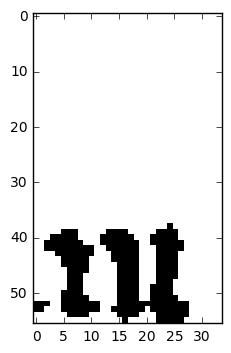

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 89.9777591228%
Elapsed time: 0.0950005054473877
---
 
Pipeline 2
Bad cut with a confidence of 68.8825309277%
Elapsed time: 0.00500035285949707
---
 
Pipeline 3
Good cut with a confidence of 89.9777591228% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 99.9998867512%
Good cut corresponding to letter 'n' with a confidence of 9.71968802332e-05%
Good cut corresponding to letter 'a' with a confidence of 8.67130580673e-06%
Elapsed time: 0.10099911689758301
---
 
Pipeline 4
Bad cut with a confidence of 68.8825309277%
Elapsed time: 0.006000041961669922
---
 
---------
 
Cut number  12


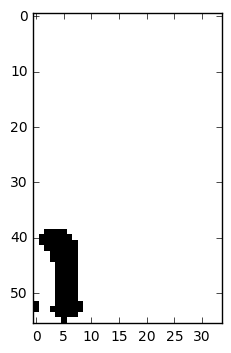

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 89.0270352364%
Elapsed time: 0.10100078582763672
---
 
Pipeline 2
Bad cut with a confidence of 69.3544209003%
Elapsed time: 0.005999326705932617
---
 
Pipeline 3
Good cut with a confidence of 89.0270352364% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9967217445%
Good cut corresponding to letter 'a' with a confidence of 0.00282144810626%
Good cut corresponding to letter 'l' with a confidence of 0.000242989062826%
Elapsed time: 0.09499979019165039
---
 
Pipeline 4
Bad cut with a confidence of 69.3544209003%
Elapsed time: 0.004999637603759766
---
 
---------
 
Cut number  13


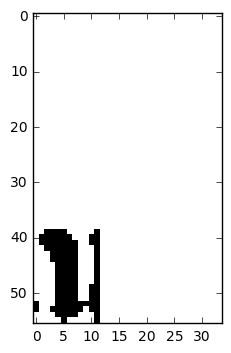

Pipeline 1
Bad cut
Elapsed time: 0.09700345993041992
---
 
Pipeline 2
Bad cut with a confidence of 63.0779802799%
Elapsed time: 0.004996538162231445
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09299921989440918
---
 
Pipeline 4
Bad cut with a confidence of 63.0779802799%
Elapsed time: 0.006000995635986328
---
 
---------
 
Cut number  14


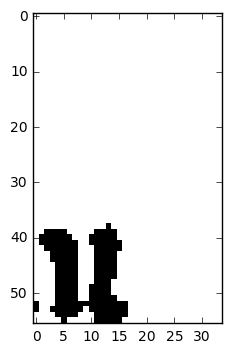

Pipeline 1
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 80.191552639%
Elapsed time: 0.0989999771118164
---
 
Pipeline 2
Good cut corresponding to letter 'u' with a confidence of 97.3533034325%
Good cut corresponding to letter 'n' with a confidence of 2.25337259471%
Good cut corresponding to letter 'e' with a confidence of 0.193879625294%
Elapsed time: 0.011999845504760742
---
 
Pipeline 3
Good cut with a confidence of 80.191552639% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 97.3533034325%
Good cut corresponding to letter 'n' with a confidence of 2.25337259471%
Good cut corresponding to letter 'e' with a confidence of 0.193879625294%
Elapsed time: 0.10500049591064453
---
 
Pipeline 4
Good cut with a confidence of 80.191552639% by letter 'u'
Elapsed time: 0.0989997386932373
---
 
---------
 
Cut number  15


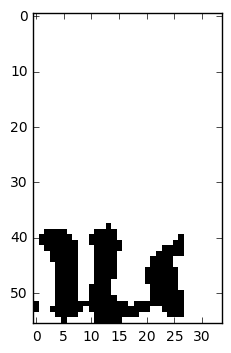

Pipeline 1
Bad cut
Elapsed time: 0.11899971961975098
---
 
Pipeline 2
Bad cut with a confidence of 98.8541007042%
Elapsed time: 0.0069997310638427734
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09200000762939453
---
 
Pipeline 4
Bad cut with a confidence of 98.8541007042%
Elapsed time: 0.0060002803802490234
---
 
---------
 
Cut number  16


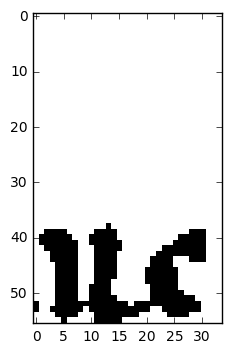

Pipeline 1
Bad cut
Elapsed time: 0.09900045394897461
---
 
Pipeline 2
Bad cut with a confidence of 99.999588728%
Elapsed time: 0.005999565124511719
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09399914741516113
---
 
Pipeline 4
Bad cut with a confidence of 99.999588728%
Elapsed time: 0.006000041961669922
---
 
---------
 
Cut number  17


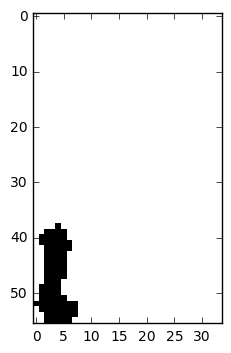

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 92.6867485046%
Elapsed time: 0.12000036239624023
---
 
Pipeline 2
Good cut corresponding to letter 'i' with a confidence of 99.9923527241%
Good cut corresponding to letter 'l' with a confidence of 0.00412180743297%
Good cut corresponding to letter 't' with a confidence of 0.00337695746566%
Elapsed time: 0.013000011444091797
---
 
Pipeline 3
Good cut with a confidence of 92.6867485046% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9923527241%
Good cut corresponding to letter 'l' with a confidence of 0.00412180743297%
Good cut corresponding to letter 't' with a confidence of 0.00337695746566%
Elapsed time: 0.10500001907348633
---
 
Pipeline 4
Good cut with a confidence of 92.6867485046% by letter 'i'
Elapsed time: 0.09999895095825195
---
 
---------
 
Cut number  18


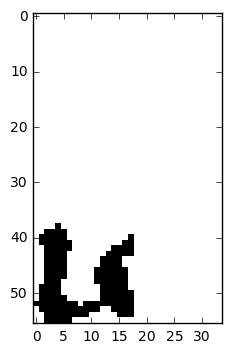

Pipeline 1
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 76.0425925255%
Elapsed time: 0.09299707412719727
---
 
Pipeline 2
Bad cut with a confidence of 95.918828249%
Elapsed time: 0.00500035285949707
---
 
Pipeline 3
Good cut with a confidence of 76.0425925255% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 99.9855220318%
Good cut corresponding to letter 'b' with a confidence of 0.010396912694%
Good cut corresponding to letter 'n' with a confidence of 0.00385231978726%
Elapsed time: 0.09599900245666504
---
 
Pipeline 4
Bad cut with a confidence of 95.918828249%
Elapsed time: 0.006000995635986328
---
 
---------
 
Cut number  19


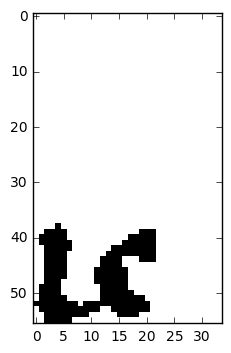

Pipeline 1
Bad cut
Elapsed time: 0.09200072288513184
---
 
Pipeline 2
Bad cut with a confidence of 96.2462902069%
Elapsed time: 0.004998683929443359
---
 
Pipeline 3
Bad cut
Elapsed time: 0.0930023193359375
---
 
Pipeline 4
Bad cut with a confidence of 96.2462902069%
Elapsed time: 0.005997657775878906
---
 
---------
 
Cut number  20


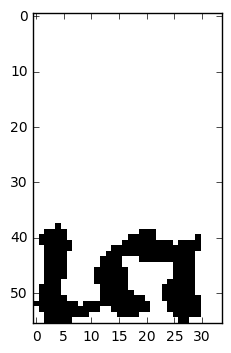

Pipeline 1
Bad cut
Elapsed time: 0.10199928283691406
---
 
Pipeline 2
Bad cut with a confidence of 99.9997258186%
Elapsed time: 0.00599980354309082
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09400129318237305
---
 
Pipeline 4
Bad cut with a confidence of 99.9997258186%
Elapsed time: 0.0050008296966552734
---
 
---------
 
Cut number  21


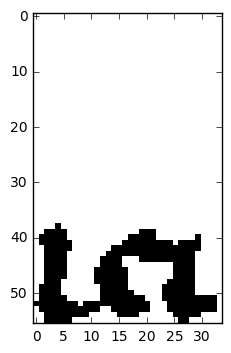

Pipeline 1
Bad cut
Elapsed time: 0.0969998836517334
---
 
Pipeline 2
Bad cut with a confidence of 99.9997258186%
Elapsed time: 0.005001068115234375
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09599828720092773
---
 
Pipeline 4
Bad cut with a confidence of 99.9997258186%
Elapsed time: 0.006000041961669922
---
 
---------
 
Cut number  22


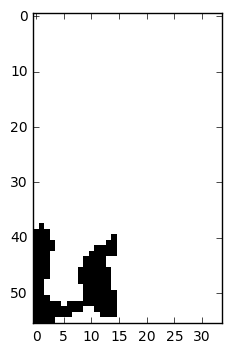

Pipeline 1
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 66.3487434387%
Cut 1 has been classified as good corresponding to char 'q' with a confidence of 60.2225661278%
Elapsed time: 0.09900331497192383
---
 
Pipeline 2
Bad cut with a confidence of 73.6614823341%
Elapsed time: 0.005997657775878906
---
 
Pipeline 3
Good cut with a confidence of 66.3487434387% by letter 'u'
Good cut with a confidence of 60.2225661278% by letter 'q'
Good cut corresponding to letter 'u' with a confidence of 99.9618887901%
Good cut corresponding to letter 'b' with a confidence of 0.0365406594938%
Good cut corresponding to letter 'n' with a confidence of 0.0007987177014%
Elapsed time: 0.09999966621398926
---
 
Pipeline 4
Bad cut with a confidence of 73.6614823341%
Elapsed time: 0.005999326705932617
---
 
---------
 
Cut number  23


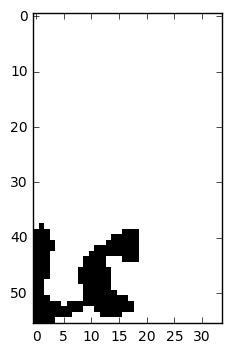

Pipeline 1
Bad cut
Elapsed time: 0.0969991683959961
---
 
Pipeline 2
Bad cut with a confidence of 70.5325007439%
Elapsed time: 0.006002187728881836
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09299826622009277
---
 
Pipeline 4
Bad cut with a confidence of 70.5325007439%
Elapsed time: 0.006000518798828125
---
 
---------
 
Cut number  24


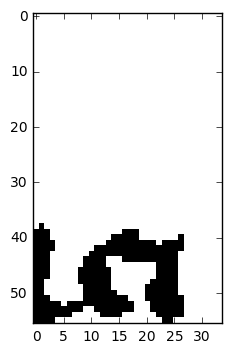

Pipeline 1
Bad cut
Elapsed time: 0.0989995002746582
---
 
Pipeline 2
Bad cut with a confidence of 99.9969124794%
Elapsed time: 0.005999565124511719
---
 
Pipeline 3
Bad cut
Elapsed time: 0.08900117874145508
---
 
Pipeline 4
Bad cut with a confidence of 99.9969124794%
Elapsed time: 0.005999565124511719
---
 
---------
 
Cut number  25


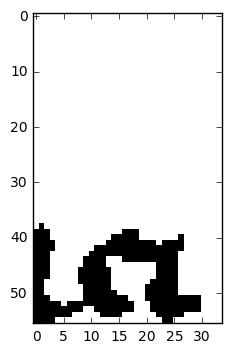

Pipeline 1
Bad cut
Elapsed time: 0.09199643135070801
---
 
Pipeline 2
Bad cut with a confidence of 99.9969124794%
Elapsed time: 0.005000114440917969
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09600043296813965
---
 
Pipeline 4
Bad cut with a confidence of 99.9969124794%
Elapsed time: 0.004999637603759766
---
 
---------
 
Cut number  26


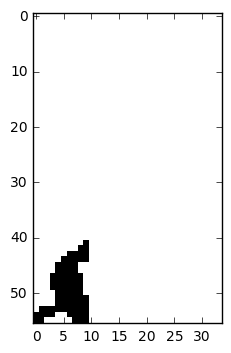

Pipeline 1
Bad cut
Elapsed time: 0.09500002861022949
---
 
Pipeline 2
Bad cut with a confidence of 99.0630984306%
Elapsed time: 0.00599980354309082
---
 
Pipeline 3
Bad cut
Elapsed time: 0.10299992561340332
---
 
Pipeline 4
Bad cut with a confidence of 99.0630984306%
Elapsed time: 0.005999088287353516
---
 
---------
 
Cut number  27


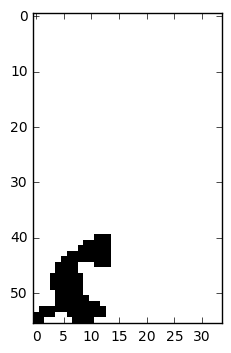

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 94.2863345146%
Elapsed time: 0.09400057792663574
---
 
Pipeline 2
Good cut corresponding to letter 'c' with a confidence of 99.0653157234%
Good cut corresponding to letter 'e' with a confidence of 0.837138202041%
Good cut corresponding to letter 'o' with a confidence of 0.0928345718421%
Elapsed time: 0.010998249053955078
---
 
Pipeline 3
Good cut with a confidence of 94.2863345146% by letter 'c'
Good cut corresponding to letter 'c' with a confidence of 99.0653157234%
Good cut corresponding to letter 'e' with a confidence of 0.837138202041%
Good cut corresponding to letter 'o' with a confidence of 0.0928345718421%
Elapsed time: 0.10100007057189941
---
 
Pipeline 4
Good cut with a confidence of 94.2863345146% by letter 'c'
Elapsed time: 0.09800124168395996
---
 
---------
 
Cut number  28


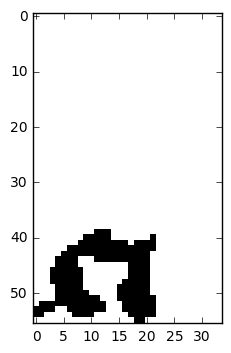

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 77.5348782539%
Elapsed time: 0.10000967979431152
---
 
Pipeline 2
Bad cut with a confidence of 99.9997973442%
Elapsed time: 0.006001472473144531
---
 
Pipeline 3
Good cut with a confidence of 77.5348782539% by letter 'c'
Good cut corresponding to letter 'd_mediana' with a confidence of 49.61360991%
Good cut corresponding to letter 'a' with a confidence of 33.448779583%
Good cut corresponding to letter 'o' with a confidence of 15.6153619289%
Elapsed time: 0.09799790382385254
---
 
Pipeline 4
Bad cut with a confidence of 99.9997973442%
Elapsed time: 0.005999326705932617
---
 
---------
 
Cut number  29


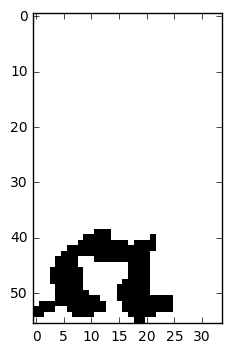

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 77.5348782539%
Elapsed time: 0.10999917984008789
---
 
Pipeline 2
Bad cut with a confidence of 99.9997973442%
Elapsed time: 0.005999565124511719
---
 
Pipeline 3
Good cut with a confidence of 77.5348782539% by letter 'c'
Good cut corresponding to letter 'd_mediana' with a confidence of 49.61360991%
Good cut corresponding to letter 'a' with a confidence of 33.448779583%
Good cut corresponding to letter 'o' with a confidence of 15.6153619289%
Elapsed time: 0.10199999809265137
---
 
Pipeline 4
Bad cut with a confidence of 99.9997973442%
Elapsed time: 0.005002021789550781
---
 
---------
 
Cut number  30


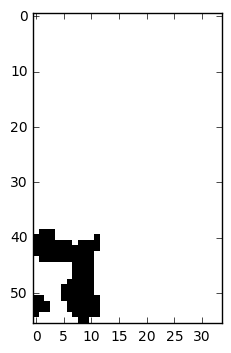

Pipeline 1
Bad cut
Elapsed time: 0.10100078582763672
---
 
Pipeline 2
Bad cut with a confidence of 99.9943435192%
Elapsed time: 0.006005048751831055
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09199404716491699
---
 
Pipeline 4
Bad cut with a confidence of 99.9943435192%
Elapsed time: 0.0060002803802490234
---
 
---------
 
Cut number  31


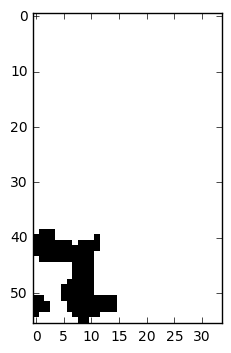

Pipeline 1
Bad cut
Elapsed time: 0.09399819374084473
---
 
Pipeline 2
Bad cut with a confidence of 99.9943435192%
Elapsed time: 0.004999876022338867
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09400010108947754
---
 
Pipeline 4
Bad cut with a confidence of 99.9943435192%
Elapsed time: 0.00500178337097168
---
 
---------
 
Cut number  32


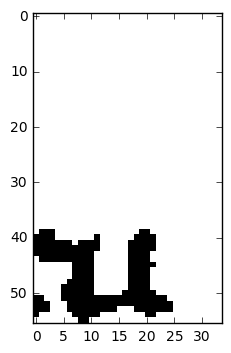

Pipeline 1
Bad cut
Elapsed time: 0.09599828720092773
---
 
Pipeline 2
Bad cut with a confidence of 99.1421580315%
Elapsed time: 0.005001068115234375
---
 
Pipeline 3
Bad cut
Elapsed time: 0.0950016975402832
---
 
Pipeline 4
Bad cut with a confidence of 99.1421580315%
Elapsed time: 0.005997657775878906
---
 
---------
 
Cut number  33


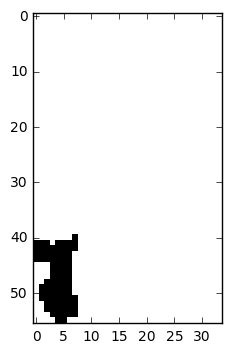

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 77.7680873871%
Elapsed time: 0.09800004959106445
---
 
Pipeline 2
Bad cut with a confidence of 93.1054413319%
Elapsed time: 0.005999565124511719
---
 
Pipeline 3
Good cut with a confidence of 77.7680873871% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9870300293%
Good cut corresponding to letter 't' with a confidence of 0.00899646329344%
Good cut corresponding to letter 'a' with a confidence of 0.00300888314086%
Elapsed time: 0.10100054740905762
---
 
Pipeline 4
Bad cut with a confidence of 93.1054413319%
Elapsed time: 0.004998922348022461
---
 
---------
 
Cut number  34


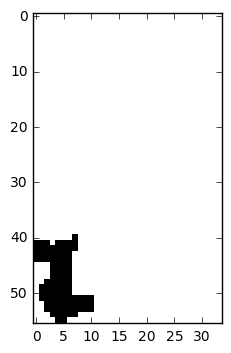

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 77.7680873871%
Elapsed time: 0.09399890899658203
---
 
Pipeline 2
Bad cut with a confidence of 93.1054413319%
Elapsed time: 0.0050013065338134766
---
 
Pipeline 3
Good cut with a confidence of 77.7680873871% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9870300293%
Good cut corresponding to letter 't' with a confidence of 0.00899646329344%
Good cut corresponding to letter 'a' with a confidence of 0.00300888314086%
Elapsed time: 0.10099959373474121
---
 
Pipeline 4
Bad cut with a confidence of 93.1054413319%
Elapsed time: 0.0070002079010009766
---
 
---------
 
Cut number  35


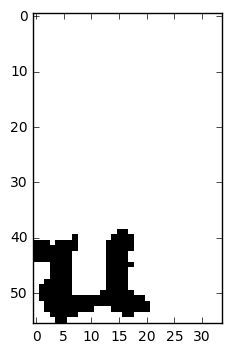

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 69.654995203%
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 99.4134902954%
Elapsed time: 0.09699797630310059
---
 
Pipeline 2
Good cut corresponding to letter 'u' with a confidence of 99.9999821186%
Good cut corresponding to letter 'a' with a confidence of 1.49210194422e-05%
Good cut corresponding to letter 'n' with a confidence of 5.02939592195e-06%
Elapsed time: 0.010998010635375977
---
 
Pipeline 3
Good cut with a confidence of 69.654995203% by letter 'i'
Good cut with a confidence of 99.4134902954% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 99.9999821186%
Good cut corresponding to letter 'a' with a confidence of 1.49210194422e-05%
Good cut corresponding to letter 'n' with a confidence of 5.02939592195e-06%
Elapsed time: 0.0970003604888916
---
 
Pipeline 4
Good cut with a confidence of 69.654995203% by letter 'i'
Good cut with a 

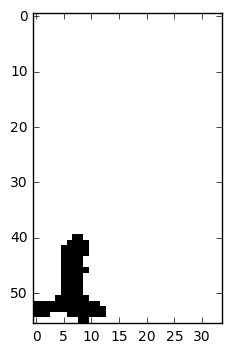

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 72.6054549217%
Elapsed time: 0.09699773788452148
---
 
Pipeline 2
Bad cut with a confidence of 70.9219753742%
Elapsed time: 0.004998445510864258
---
 
Pipeline 3
Good cut with a confidence of 72.6054549217% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.962246418%
Good cut corresponding to letter 't' with a confidence of 0.020666338969%
Good cut corresponding to letter 'a' with a confidence of 0.0076298660133%
Elapsed time: 0.10300159454345703
---
 
Pipeline 4
Bad cut with a confidence of 70.9219753742%
Elapsed time: 0.0059967041015625
---
 
---------
 
Cut number  37


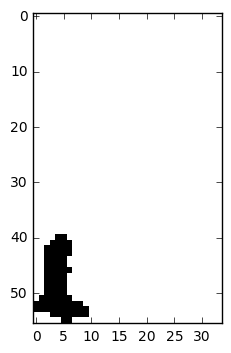

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 88.0010247231%
Elapsed time: 0.09499955177307129
---
 
Pipeline 2
Bad cut with a confidence of 76.4873683453%
Elapsed time: 0.006000041961669922
---
 
Pipeline 3
Good cut with a confidence of 88.0010247231% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9717831612%
Good cut corresponding to letter 't' with a confidence of 0.0172225496499%
Good cut corresponding to letter 'e' with a confidence of 0.00436022201029%
Elapsed time: 0.0989990234375
---
 
Pipeline 4
Bad cut with a confidence of 76.4873683453%
Elapsed time: 0.0060002803802490234
---
 
---------
 


In [15]:
for i in range(0,len(cuts)):
    print("Cut number ", i+1)
    u.plot_image(cuts[i], (img_cols, img_rows))
    print("Pipeline 1")
    predict_pipeline1([cuts[i]], count_letter=False)
    print("Pipeline 2")
    predict_pipeline2([cuts[i]], count_letter=False)
    print("Pipeline 3")
    predict_pipeline3([cuts[i]], count_letter=False)
    print("Pipeline 4")
    predict_pipeline4([cuts[i]], count_letter=False)
    print("---------")
    print(" ")

### "Igitur"

Examples: 


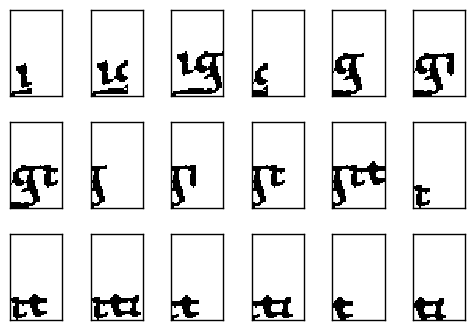

In [16]:
files = []
folders = []
for (path, dirnames, filenames) in os.walk(os.path.join('not_code',os.path.join('word_segments','igitur'))):
    folders.extend(os.path.join(path, name) for name in dirnames)
    files.extend(os.path.join(path, name) for name in filenames)

files.sort(key=natural_keys)

cuts = iu.open_many_samples(files)
(cuts, _) = kiu.adjust_input(np.asarray(cuts))

print ("Examples: ")
u.plot_some_images(cuts[:18], (img_cols, img_rows), grid_x=6, grid_y=3)

Cut number  1


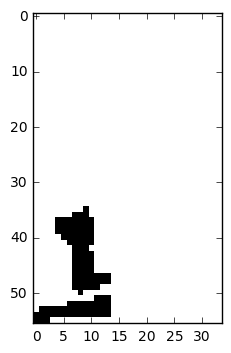

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 57.4443697929%
Elapsed time: 0.09799933433532715
---
 
Pipeline 2
Good cut corresponding to letter 'i' with a confidence of 99.7274577618%
Good cut corresponding to letter 'l' with a confidence of 0.265830405988%
Good cut corresponding to letter 'a' with a confidence of 0.00594859011471%
Elapsed time: 0.011998891830444336
---
 
Pipeline 3
Good cut with a confidence of 57.4443697929% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.7274577618%
Good cut corresponding to letter 'l' with a confidence of 0.265830405988%
Good cut corresponding to letter 'a' with a confidence of 0.00594859011471%
Elapsed time: 0.1119997501373291
---
 
Pipeline 4
Good cut with a confidence of 57.4443697929% by letter 'i'
Elapsed time: 0.09900045394897461
---
 
---------
 
Cut number  2


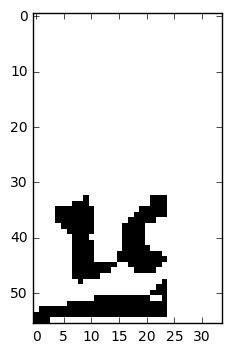

Pipeline 1
Bad cut
Elapsed time: 0.10100007057189941
---
 
Pipeline 2
Bad cut with a confidence of 85.1346969604%
Elapsed time: 0.0060002803802490234
---
 
Pipeline 3
Bad cut
Elapsed time: 0.0970003604888916
---
 
Pipeline 4
Bad cut with a confidence of 85.1346969604%
Elapsed time: 0.007001399993896484
---
 
---------
 
Cut number  3


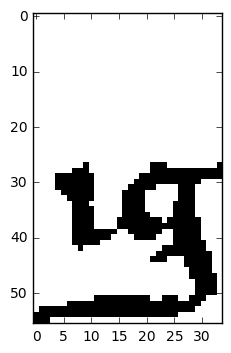

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 85.327988863%
Elapsed time: 0.10099983215332031
---
 
Pipeline 2
Bad cut with a confidence of 99.9999880791%
Elapsed time: 0.00699925422668457
---
 
Pipeline 3
Good cut with a confidence of 85.327988863% by letter 's_mediana'
Good cut corresponding to letter 'g' with a confidence of 75.2617001534%
Good cut corresponding to letter 'p' with a confidence of 19.6034237742%
Good cut corresponding to letter 'q' with a confidence of 5.13486489654%
Elapsed time: 0.09800028800964355
---
 
Pipeline 4
Bad cut with a confidence of 99.9999880791%
Elapsed time: 0.00599980354309082
---
 
---------
 
Cut number  4


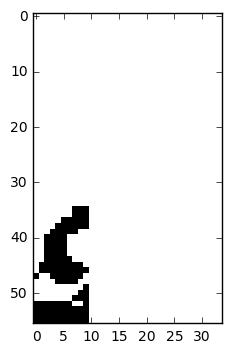

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 90.126478672%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.2351710796%
Elapsed time: 0.09999942779541016
---
 
Pipeline 2
Bad cut with a confidence of 99.8802959919%
Elapsed time: 0.005002021789550781
---
 
Pipeline 3
Good cut with a confidence of 90.126478672% by letter 'c'
Good cut with a confidence of 99.2351710796% by letter 's_mediana'
Good cut corresponding to letter 'c' with a confidence of 98.5993862152%
Good cut corresponding to letter 's_alta' with a confidence of 0.992051418871%
Good cut corresponding to letter 'e' with a confidence of 0.185914151371%
Elapsed time: 0.09999799728393555
---
 
Pipeline 4
Bad cut with a confidence of 99.8802959919%
Elapsed time: 0.006000518798828125
---
 
---------
 
Cut number  5


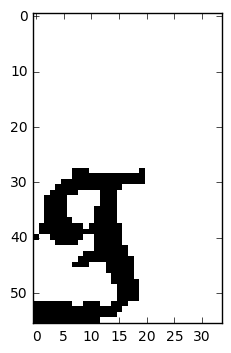

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 93.4666335583%
Cut 1 has been classified as good corresponding to char 'g' with a confidence of 99.9185860157%
Elapsed time: 0.09499597549438477
---
 
Pipeline 2
Good cut corresponding to letter 'g' with a confidence of 99.9994277954%
Good cut corresponding to letter 'q' with a confidence of 0.000378965842174%
Good cut corresponding to letter 's_bassa' with a confidence of 0.000196392511498%
Elapsed time: 0.0110015869140625
---
 
Pipeline 3
Good cut with a confidence of 93.4666335583% by letter 's_mediana'
Good cut with a confidence of 99.9185860157% by letter 'g'
Good cut corresponding to letter 'g' with a confidence of 99.9994277954%
Good cut corresponding to letter 'q' with a confidence of 0.000378965842174%
Good cut corresponding to letter 's_bassa' with a confidence of 0.000196392511498%
Elapsed time: 0.09999942779541016
---
 
Pipeline 4
Good cut with a confidence of 93.4666335583% 

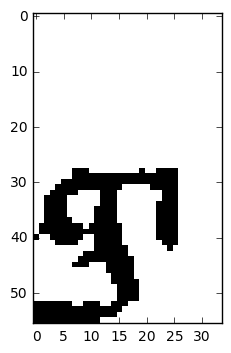

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 97.0946669579%
Cut 1 has been classified as good corresponding to char 'g' with a confidence of 97.7661252022%
Elapsed time: 0.09699654579162598
---
 
Pipeline 2
Bad cut with a confidence of 59.5898747444%
Elapsed time: 0.005999326705932617
---
 
Pipeline 3
Good cut with a confidence of 97.0946669579% by letter 's_mediana'
Good cut with a confidence of 97.7661252022% by letter 'g'
Good cut corresponding to letter 'g' with a confidence of 97.0942318439%
Good cut corresponding to letter 'p' with a confidence of 2.65142656863%
Good cut corresponding to letter 'q' with a confidence of 0.254284474067%
Elapsed time: 0.0989997386932373
---
 
Pipeline 4
Bad cut with a confidence of 59.5898747444%
Elapsed time: 0.004999876022338867
---
 
---------
 
Cut number  7


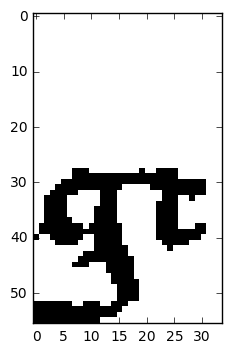

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 98.1415390968%
Cut 1 has been classified as good corresponding to char 'g' with a confidence of 62.5159978867%
Elapsed time: 0.09199810028076172
---
 
Pipeline 2
Bad cut with a confidence of 99.9962329865%
Elapsed time: 0.006002902984619141
---
 
Pipeline 3
Good cut with a confidence of 98.1415390968% by letter 's_mediana'
Good cut with a confidence of 62.5159978867% by letter 'g'
Good cut corresponding to letter 'g' with a confidence of 93.5825943947%
Good cut corresponding to letter 'p' with a confidence of 5.19085451961%
Good cut corresponding to letter 'q' with a confidence of 1.2264338322%
Elapsed time: 0.09999537467956543
---
 
Pipeline 4
Bad cut with a confidence of 99.9962329865%
Elapsed time: 0.006002187728881836
---
 
---------
 
Cut number  8


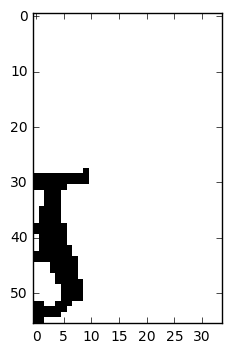

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 73.8838553429%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 59.1341137886%
Elapsed time: 0.09699630737304688
---
 
Pipeline 2
Bad cut with a confidence of 97.628057003%
Elapsed time: 0.005997419357299805
---
 
Pipeline 3
Good cut with a confidence of 73.8838553429% by letter 's_mediana'
Good cut with a confidence of 59.1341137886% by letter 's_alta'
Good cut corresponding to letter 'l' with a confidence of 99.2590308189%
Good cut corresponding to letter 's_alta' with a confidence of 0.740307709202%
Good cut corresponding to letter 's_bassa' with a confidence of 0.000455378904007%
Elapsed time: 0.09701085090637207
---
 
Pipeline 4
Bad cut with a confidence of 97.628057003%
Elapsed time: 0.00600123405456543
---
 
---------
 
Cut number  9


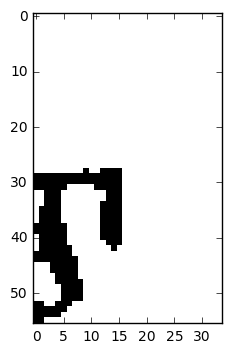

Pipeline 1
Cut 1 has been classified as good corresponding to char 'h' with a confidence of 85.9342455864%
Elapsed time: 0.09900116920471191
---
 
Pipeline 2
Good cut corresponding to letter 'p' with a confidence of 99.7105300426%
Good cut corresponding to letter 's_alta' with a confidence of 0.229548453353%
Good cut corresponding to letter 'q' with a confidence of 0.0569534371607%
Elapsed time: 0.012998580932617188
---
 
Pipeline 3
Good cut with a confidence of 85.9342455864% by letter 'h'
Good cut corresponding to letter 'p' with a confidence of 99.7105300426%
Good cut corresponding to letter 's_alta' with a confidence of 0.229548453353%
Good cut corresponding to letter 'q' with a confidence of 0.0569534371607%
Elapsed time: 0.10599970817565918
---
 
Pipeline 4
Good cut with a confidence of 85.9342455864% by letter 'h'
Elapsed time: 0.10299992561340332
---
 
---------
 
Cut number  10


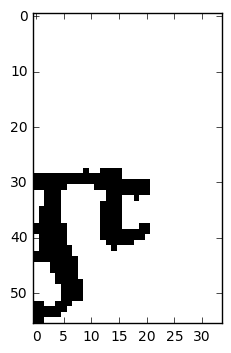

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 88.5766327381%
Elapsed time: 0.1009981632232666
---
 
Pipeline 2
Good cut corresponding to letter 'p' with a confidence of 99.9810397625%
Good cut corresponding to letter 'q' with a confidence of 0.0158468727022%
Good cut corresponding to letter 's_alta' with a confidence of 0.0016830421373%
Elapsed time: 0.013000726699829102
---
 
Pipeline 3
Good cut with a confidence of 88.5766327381% by letter 's_mediana'
Good cut corresponding to letter 'p' with a confidence of 99.9810397625%
Good cut corresponding to letter 'q' with a confidence of 0.0158468727022%
Good cut corresponding to letter 's_alta' with a confidence of 0.0016830421373%
Elapsed time: 0.0989995002746582
---
 
Pipeline 4
Good cut with a confidence of 88.5766327381% by letter 's_mediana'
Elapsed time: 0.10000205039978027
---
 
---------
 
Cut number  11


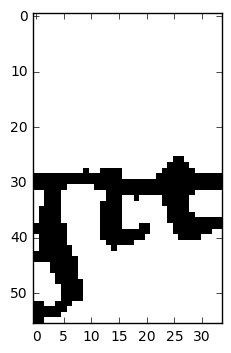

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 98.4465122223%
Elapsed time: 0.09699892997741699
---
 
Pipeline 2
Bad cut with a confidence of 100.0%
Elapsed time: 0.005997896194458008
---
 
Pipeline 3
Good cut with a confidence of 98.4465122223% by letter 's_mediana'
Good cut corresponding to letter 'p' with a confidence of 99.7697174549%
Good cut corresponding to letter 'g' with a confidence of 0.203544157557%
Good cut corresponding to letter 'q' with a confidence of 0.0182627816685%
Elapsed time: 0.10200214385986328
---
 
Pipeline 4
Bad cut with a confidence of 100.0%
Elapsed time: 0.005999088287353516
---
 
---------
 
Cut number  12


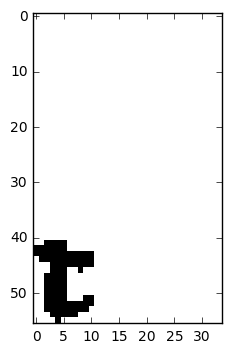

Pipeline 1
Bad cut
Elapsed time: 0.0970008373260498
---
 
Pipeline 2
Bad cut with a confidence of 97.2084164619%
Elapsed time: 0.004997968673706055
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09500002861022949
---
 
Pipeline 4
Bad cut with a confidence of 97.2084164619%
Elapsed time: 0.00599980354309082
---
 
---------
 
Cut number  13


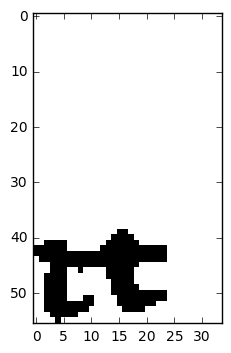

Pipeline 1
Bad cut
Elapsed time: 0.09299659729003906
---
 
Pipeline 2
Bad cut with a confidence of 99.9107241631%
Elapsed time: 0.006002187728881836
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09399938583374023
---
 
Pipeline 4
Bad cut with a confidence of 99.9107241631%
Elapsed time: 0.004998922348022461
---
 
---------
 
Cut number  14


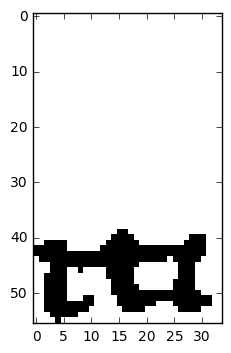

Pipeline 1
Bad cut
Elapsed time: 0.09299731254577637
---
 
Pipeline 2
Bad cut with a confidence of 99.9981880188%
Elapsed time: 0.005001068115234375
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09199976921081543
---
 
Pipeline 4
Bad cut with a confidence of 99.9981880188%
Elapsed time: 0.004998445510864258
---
 
---------
 
Cut number  15


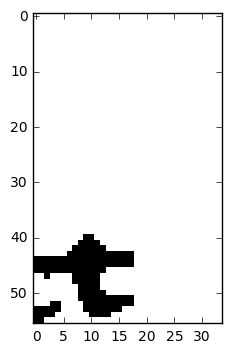

Pipeline 1
Cut 1 has been classified as good corresponding to char 't' with a confidence of 88.698464632%
Elapsed time: 0.09200096130371094
---
 
Pipeline 2
Good cut corresponding to letter 't' with a confidence of 99.0746200085%
Good cut corresponding to letter 'e' with a confidence of 0.737214460969%
Good cut corresponding to letter 'a' with a confidence of 0.185976049397%
Elapsed time: 0.013000249862670898
---
 
Pipeline 3
Good cut with a confidence of 88.698464632% by letter 't'
Good cut corresponding to letter 't' with a confidence of 99.0746200085%
Good cut corresponding to letter 'e' with a confidence of 0.737214460969%
Good cut corresponding to letter 'a' with a confidence of 0.185976049397%
Elapsed time: 0.10700058937072754
---
 
Pipeline 4
Good cut with a confidence of 88.698464632% by letter 't'
Elapsed time: 0.09999799728393555
---
 
---------
 
Cut number  16


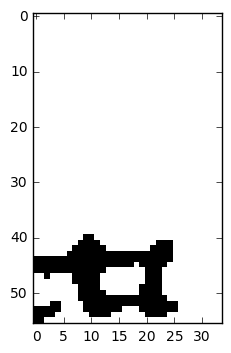

Pipeline 1
Bad cut
Elapsed time: 0.09700226783752441
---
 
Pipeline 2
Bad cut with a confidence of 99.9997019768%
Elapsed time: 0.0059969425201416016
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09400200843811035
---
 
Pipeline 4
Bad cut with a confidence of 99.9997019768%
Elapsed time: 0.004998445510864258
---
 
---------
 
Cut number  17


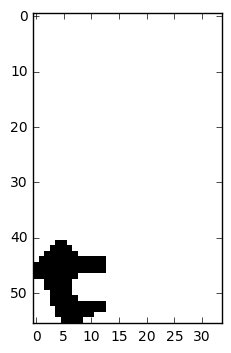

Pipeline 1
Cut 1 has been classified as good corresponding to char 'e' with a confidence of 55.3957760334%
Cut 1 has been classified as good corresponding to char 't' with a confidence of 89.7847533226%
Elapsed time: 0.09599709510803223
---
 
Pipeline 2
Good cut corresponding to letter 't' with a confidence of 65.7572567463%
Good cut corresponding to letter 'e' with a confidence of 19.0896958113%
Good cut corresponding to letter 'i' with a confidence of 13.5592788458%
Elapsed time: 0.012000083923339844
---
 
Pipeline 3
Good cut with a confidence of 55.3957760334% by letter 'e'
Good cut with a confidence of 89.7847533226% by letter 't'
Good cut corresponding to letter 't' with a confidence of 65.7572567463%
Good cut corresponding to letter 'e' with a confidence of 19.0896958113%
Good cut corresponding to letter 'i' with a confidence of 13.5592788458%
Elapsed time: 0.09600138664245605
---
 
Pipeline 4
Good cut with a confidence of 55.3957760334% by letter 'e'
Good cut with a confidence o

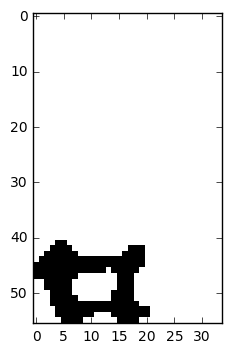

Pipeline 1
Bad cut
Elapsed time: 0.09999847412109375
---
 
Pipeline 2
Bad cut with a confidence of 99.9600231647%
Elapsed time: 0.0070002079010009766
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09100127220153809
---
 
Pipeline 4
Bad cut with a confidence of 99.9600231647%
Elapsed time: 0.005998373031616211
---
 
---------
 
Cut number  19


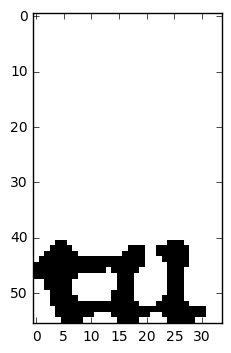

Pipeline 1
Bad cut
Elapsed time: 0.09799957275390625
---
 
Pipeline 2
Bad cut with a confidence of 99.9942183495%
Elapsed time: 0.0060007572174072266
---
 
Pipeline 3
Bad cut
Elapsed time: 0.09599900245666504
---
 
Pipeline 4
Bad cut with a confidence of 99.9942183495%
Elapsed time: 0.00500035285949707
---
 
---------
 
Cut number  20


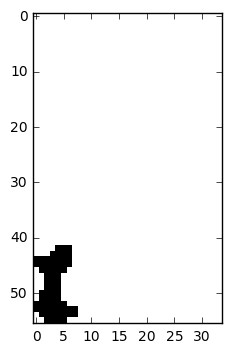

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 64.8233473301%
Elapsed time: 0.10199642181396484
---
 
Pipeline 2
Bad cut with a confidence of 98.7990856171%
Elapsed time: 0.006000995635986328
---
 
Pipeline 3
Good cut with a confidence of 64.8233473301% by letter 'c'
Good cut corresponding to letter 'c' with a confidence of 55.1802992821%
Good cut corresponding to letter 'i' with a confidence of 40.3107106686%
Good cut corresponding to letter 'e' with a confidence of 4.21490594745%
Elapsed time: 0.09600019454956055
---
 
Pipeline 4
Bad cut with a confidence of 98.7990856171%
Elapsed time: 0.0059986114501953125
---
 
---------
 
Cut number  21


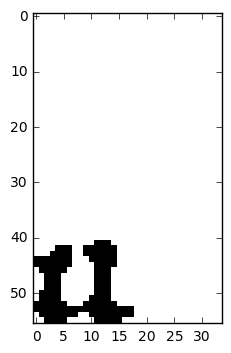

Pipeline 1
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 90.9387767315%
Elapsed time: 0.09799981117248535
---
 
Pipeline 2
Good cut corresponding to letter 'u' with a confidence of 96.5057969093%
Good cut corresponding to letter 'n' with a confidence of 1.95097904652%
Good cut corresponding to letter 'e' with a confidence of 1.0516313836%
Elapsed time: 0.00999903678894043
---
 
Pipeline 3
Good cut with a confidence of 90.9387767315% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 96.5057969093%
Good cut corresponding to letter 'n' with a confidence of 1.95097904652%
Good cut corresponding to letter 'e' with a confidence of 1.0516313836%
Elapsed time: 0.10000181198120117
---
 
Pipeline 4
Good cut with a confidence of 90.9387767315% by letter 'u'
Elapsed time: 0.09999871253967285
---
 
---------
 
Cut number  22


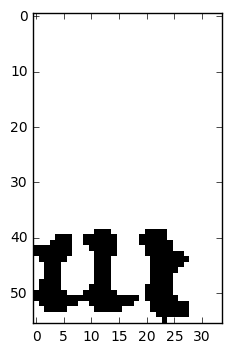

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 81.9326996803%
Elapsed time: 0.09800171852111816
---
 
Pipeline 2
Bad cut with a confidence of 80.4500877857%
Elapsed time: 0.006998300552368164
---
 
Pipeline 3
Good cut with a confidence of 81.9326996803% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 99.9979019165%
Good cut corresponding to letter 'n' with a confidence of 0.00209643076232%
Good cut corresponding to letter 'e' with a confidence of 6.5278724648e-07%
Elapsed time: 0.10300087928771973
---
 
Pipeline 4
Bad cut with a confidence of 80.4500877857%
Elapsed time: 0.005998849868774414
---
 
---------
 
Cut number  23


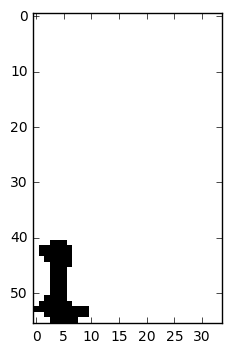

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 83.2819759846%
Elapsed time: 0.10099959373474121
---
 
Pipeline 2
Bad cut with a confidence of 75.4600942135%
Elapsed time: 0.0069980621337890625
---
 
Pipeline 3
Good cut with a confidence of 83.2819759846% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9934196472%
Good cut corresponding to letter 'a' with a confidence of 0.00204966690944%
Good cut corresponding to letter 't' with a confidence of 0.00195133288798%
Elapsed time: 0.10600042343139648
---
 
Pipeline 4
Bad cut with a confidence of 75.4600942135%
Elapsed time: 0.00599980354309082
---
 
---------
 
Cut number  24


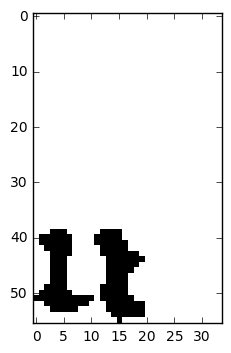

Pipeline 1
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 93.0464446545%
Elapsed time: 0.10199570655822754
---
 
Pipeline 2
Good cut corresponding to letter 'u' with a confidence of 99.8232543468%
Good cut corresponding to letter 'n' with a confidence of 0.176125694998%
Good cut corresponding to letter 'a' with a confidence of 0.000512983297085%
Elapsed time: 0.011998653411865234
---
 
Pipeline 3
Good cut with a confidence of 93.0464446545% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 99.8232543468%
Good cut corresponding to letter 'n' with a confidence of 0.176125694998%
Good cut corresponding to letter 'a' with a confidence of 0.000512983297085%
Elapsed time: 0.10300183296203613
---
 
Pipeline 4
Good cut with a confidence of 93.0464446545% by letter 'u'
Elapsed time: 0.10399818420410156
---
 
---------
 
Cut number  25


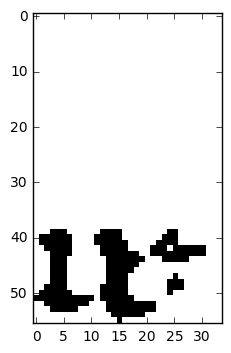

Pipeline 1
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 88.2557272911%
Elapsed time: 0.10299849510192871
---
 
Pipeline 2
Bad cut with a confidence of 93.9725756645%
Elapsed time: 0.004998922348022461
---
 
Pipeline 3
Good cut with a confidence of 88.2557272911% by letter 'u'
Good cut corresponding to letter 'm' with a confidence of 75.4696309566%
Good cut corresponding to letter 'u' with a confidence of 15.4750019312%
Good cut corresponding to letter 'n' with a confidence of 8.9969702065%
Elapsed time: 0.10399961471557617
---
 
Pipeline 4
Bad cut with a confidence of 93.9725756645%
Elapsed time: 0.007000446319580078
---
 
---------
 
Cut number  26


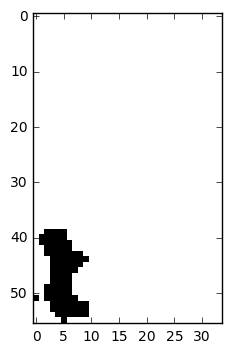

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 75.6008625031%
Elapsed time: 0.09899663925170898
---
 
Pipeline 2
Bad cut with a confidence of 99.561136961%
Elapsed time: 0.0060002803802490234
---
 
Pipeline 3
Good cut with a confidence of 75.6008625031% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9166190624%
Good cut corresponding to letter 'a' with a confidence of 0.0798998749815%
Good cut corresponding to letter 'l' with a confidence of 0.00110150231194%
Elapsed time: 0.0970010757446289
---
 
Pipeline 4
Bad cut with a confidence of 99.561136961%
Elapsed time: 0.005999088287353516
---
 
---------
 
Cut number  27


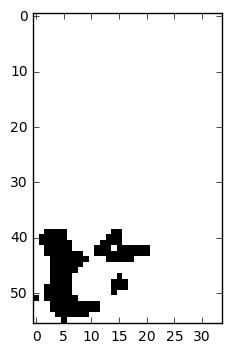

Pipeline 1
Cut 1 has been classified as good corresponding to char 'r' with a confidence of 71.2891876698%
Elapsed time: 0.09599733352661133
---
 
Pipeline 2
Bad cut with a confidence of 74.341237545%
Elapsed time: 0.005998373031616211
---
 
Pipeline 3
Good cut with a confidence of 71.2891876698% by letter 'r'
Good cut corresponding to letter 'r' with a confidence of 99.9496757984%
Good cut corresponding to letter 't' with a confidence of 0.0337328645401%
Good cut corresponding to letter 'e' with a confidence of 0.00953426788328%
Elapsed time: 0.10300159454345703
---
 
Pipeline 4
Bad cut with a confidence of 74.341237545%
Elapsed time: 0.006001710891723633
---
 
---------
 
Cut number  28


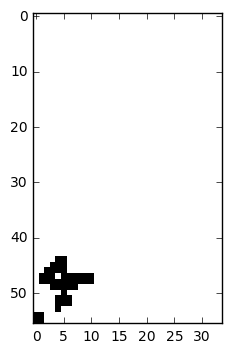

Pipeline 1
Bad cut
Elapsed time: 0.11100029945373535
---
 
Pipeline 2
Bad cut with a confidence of 97.6968944073%
Elapsed time: 0.0069997310638427734
---
 
Pipeline 3
Bad cut
Elapsed time: 0.10899972915649414
---
 
Pipeline 4
Bad cut with a confidence of 97.6968944073%
Elapsed time: 0.0060002803802490234
---
 
---------
 


In [17]:
for i in range(0,len(cuts)):
    print("Cut number ", i+1)
    u.plot_image(cuts[i], (img_cols, img_rows))
    print("Pipeline 1")
    predict_pipeline1([cuts[i]], count_letter=False)
    print("Pipeline 2")
    predict_pipeline2([cuts[i]], count_letter=False)
    print("Pipeline 3")
    predict_pipeline3([cuts[i]], count_letter=False)
    print("Pipeline 4")
    predict_pipeline4([cuts[i]], count_letter=False)
    print("---------")
    print(" ")